In [88]:
import os
import json

import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro   # Test de normalidad
from sklearn.preprocessing import RobustScaler

# Para contar los temas
import ast
from collections import Counter

# Trabajo con elementos geográficos
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import pickle

from tqdm import tqdm  # Para ver barras de progreso en loops

Creamos la lista de columnas y dataframe vacío de la información que podemos obtener de los .json de Ground News descargados desde Internet Archive:

In [2]:
# Define the columns for the DataFrame
dataframe_columns = {
    "snapshot_date": [],   # string con la fecha, hora, minuto, segundo
    "title": [],   # Título de noticia
    "url": [],   # Enlace a la noticia en la web de Ground News
    "bias_num_sources": [],   # Número de fuentes de la noticia, para las que se conoce el sesgo
    "all_sources": [],   # Número de funtes que cubren la noticia
    "description": [],   # Explicación de la noticia en 1-3 frases.
    "place": [],   # Ubicación de la noticia
    "subject": [],   # Tema(s)/tag(s) de la noticia
    "pct_left": [],   # % medios de izquierda que cubren la noticia
    "pct_centre": [],   # % centro
    "pct_right": [],   # % derecha
    "coverage_profile": [],   # Comentario sobre la cobertura
    "low_fact": [],   # Número de medios de baja factualidad que cubren la noticia
    "mixed_fact": [],   # Número de medios de factualidad intermedia/variable que cubren la noticia
    "high_fact": [],   # Número de medios de alta factualidad que cubren la noticia
    "unknown_fact": [],    # Número de medios de factualidad desconocida que cubren la noticia
    "own_telecom": [],   # Propiedad: empresa de telecomunicaciones
    "own_privateEquity": [],   # Prop: inv. privados
    "own_mediaConglomerate": [],   # Prop: conglomerado audiovisual
    "own_billionaire": [],   # Prop: millonario
    "own_government": [],   # Prop: gobierno
    "own_independent": [],   # Prop: independiente
    "own_other": [],   # Prop: otros
    "own_uncategorized": [],
    "own_corporation": [],   # Prop: gran corporación
    "top_story": [],   # Categórica: titular principal
    "breaking_story": [],   # Categórica: noticia urgente o de última hora
    "highlighted_blindspot": []   # Categórica: noticia punto ciego destacado
}

# Create an empty DataFrame with the specified columns
ground_news_df = pd.DataFrame(dataframe_columns)

ground_news_df

Empty DataFrame
Columns: [snapshot_date, title, url, bias_num_sources, all_sources, description, place, subject, pct_left, pct_centre, pct_right, coverage_profile, low_fact, mixed_fact, high_fact, unknown_fact, own_telecom, own_privateEquity, own_mediaConglomerate, own_billionaire, own_government, own_independent, own_other, own_uncategorized, own_corporation, top_story, breaking_story, highlighted_blindspot]
Index: []

[0 rows x 28 columns]

Indicamos el directorio en el cual están los .json descargados y le indicamos que guarde el nombre de los archivos ahí contenidos:

In [3]:
folder_path = r'C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data'
internet_archive_snapshots = os.listdir(folder_path)

In [4]:
internet_archive_snapshots

['20220222033957.json',
 '20220223050905.json',
 '20220224024458.json',
 '20220225012658.json',
 '20220227003212.json',
 '20220301001404.json',
 '20220302143131.json',
 '20220303093629.json',
 '20220303134026.json',
 '20220303154553.json',
 '20220303192815.json',
 '20220306165733.json',
 '20220307194557.json',
 '20220308124716.json',
 '20220308192435.json',
 '20220309034329.json',
 '20220309110559.json',
 '20220310140928.json',
 '20220313005205.json',
 '20220313022508.json',
 '20220313091908.json',
 '20220313103145.json',
 '20220313135950.json',
 '20220313181036.json',
 '20220313191912.json',
 '20220313225444.json',
 '20220316034936.json',
 '20220316094141.json',
 '20220317215503.json',
 '20220317232954.json',
 '20220326043135.json',
 '20220326121813.json',
 '20220326132916.json',
 '20220328044417.json',
 '20220328163033.json',
 '20220401001131.json',
 '20220403115402.json',
 '20220405113336.json',
 '20220405132025.json',
 '20220407161330.json',
 '20220411113546.json',
 '20220411180855

Creamos la ruta completa para cada fichero:

In [5]:
for filename in internet_archive_snapshots:
    full_path = os.path.join(folder_path, filename)
    print(full_path)

C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220222033957.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220223050905.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220224024458.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220225012658.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220227003212.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220301001404.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220302143131.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220303093629.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220303134026.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220303154553.json
C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Fi

A partir de la ruta de cada uno de los ficheros .json, extraemos la información de los siguientes apartados: "events" (artículos ordinarios), "topStory" (titular principal), "blindspots" (puntos ciegos destacados), y "breakingStories" (historias de última hora). Recopilar todos estos, es la forma de maximizar el número de artículos totales que cosechamos. Además, esta categorización pudiera tener alguna relevancia más adelante (p.ej. ¿qué fue titular principal y qué no?).

In [6]:
for filename in internet_archive_snapshots:
    full_path = os.path.join(folder_path, filename)
    print(f"Processing file: {full_path}")
    with open(full_path, 'r') as file:
        json_data = json.load(file)
        
        for event in json_data["props"]["pageProps"].get("events", []): 
            snapshot_date = filename.split('.')[0]
            title = event.get("title", "No Title Available")
            slug = event.get("slug", "default-slug")
            url = f"https://ground.news/article/{slug}"
            bias_num_sources = event.get("biasSourceCount", 0)
            all_sources = event["sourceCount"]
            description = event.get("description", "No Description Available")
            place = event.get("place", {}).get("name", "Unknown Location")
            subject = [interest.get("name", "No Interest Name") for interest in event.get("interests", [])]

            try:
                blindspotData = event.get("blindspotData") if event.get("blindspotData") is not None else {}
                pct_left = blindspotData.get("leftPercent", 0)
                pct_centre = blindspotData.get("centerPercent", 0)
                pct_right = blindspotData.get("rightPercent", 0)
            except AttributeError as e:
                print(f"Error occurred: {e}")
                print(f"Event causing error: {event}")
                continue  # Skip this iteration and move to the next            
            
            coverage_profile = blindspotData.get("coverageProfileStatement", "No Coverage Profile")
            factuality = event.get("factuality", {})
            low_fact = factuality.get("low", 0)
            mixed_fact = factuality.get("mixed", 0)
            high_fact = factuality.get("high", 0)
            unknown_fact = factuality.get("unknown", 0)
            ownership = event.get("ownership", {})
            own_telecom = ownership.get("telecom", 0)
            own_privateEquity = ownership.get("privateEquity", 0)
            own_mediaConglomerate = ownership.get("mediaConglomerate", 0)
            own_billionaire = ownership.get("billionaire", 0)
            own_government = ownership.get("government", 0)
            own_independent = ownership.get("independent", 0)
            own_other = ownership.get("other", 0)
            own_uncategorized = ownership.get("uncategorized", 0)
            own_corporation = ownership.get("corporation", 0)
            top_story = 0
            breaking_story = 0
            highlighted_blindspot = 0

            new_row = {
                "snapshot_date": snapshot_date, "title": title, "url": url, "bias_num_sources": bias_num_sources, 
                "all_sources": all_sources, "description": description, "place": place, "subject": str(subject), "pct_left": pct_left, 
                "pct_centre": pct_centre, "pct_right": pct_right, "coverage_profile": coverage_profile, "low_fact": low_fact, 
                "mixed_fact": mixed_fact, "high_fact": high_fact, "unknown_fact": unknown_fact, "own_mediaConglomerate": own_mediaConglomerate, 
                "own_corporation": own_corporation, "own_billionaire": own_billionaire, "own_privateEquity": own_privateEquity,
                "own_telecom": own_telecom, "own_government": own_government, "own_independent": own_independent,
                "own_other": own_other, "own_uncategorized": own_uncategorized, "top_story" : top_story,
                "breaking_story": breaking_story, "highlighted_blindspot": highlighted_blindspot
            }
            new_row_df = pd.DataFrame([new_row])
            ground_news_df = pd.concat([ground_news_df, new_row_df], ignore_index=True)
            
            
        # Correctly accessing "topStory", assuming it might not be present
        top_story = json_data["props"]["pageProps"].get("topStory", None)
        if top_story:  # Check if "topStory" exists
            snapshot_date = filename.split('.')[0]
            # Use the same logic as for "events" to handle "topStory"
            title = top_story.get("title", "No Title Available")
            slug = top_story.get("slug", "default-slug")
            url = f"https://ground.news/article/{slug}"
            bias_num_sources = top_story.get("biasSourceCount", 0)
            all_sources = len(top_story.get("sources", []))  # Assuming "sources" is a list
            description = top_story.get("description", "No Description Available")
            place = top_story.get("place", {}).get("name", "Unknown Location")
            subject = [interest.get("name", "No Interest Name") for interest in top_story.get("interests", [])]
            blindspotData = top_story.get("blindspotData", {})
            pct_left = blindspotData.get("leftPercent", 0)
            pct_centre = blindspotData.get("centerPercent", 0)
            pct_right = blindspotData.get("rightPercent", 0)
            coverage_profile = blindspotData.get("coverageProfileStatement", "No Coverage Profile")
            factuality = top_story.get("factuality", {})
            low_fact = factuality.get("low", 0)
            mixed_fact = factuality.get("mixed", 0)
            high_fact = factuality.get("high", 0)
            unknown_fact = factuality.get("unknown", 0)
            ownership = top_story.get("ownership", {})
            own_telecom = ownership.get("telecom", 0)
            own_privateEquity = ownership.get("privateEquity", 0)
            own_mediaConglomerate = ownership.get("mediaConglomerate", 0)
            own_billionaire = ownership.get("billionaire", 0)
            own_government = ownership.get("government", 0)
            own_independent = ownership.get("independent", 0)
            own_other = ownership.get("other", 0)
            own_uncategorized = ownership.get("uncategorized", 0)
            own_corporation = ownership.get("corporation", 0)
            top_story = 1
            breaking_story = 0
            highlighted_blindspot = 0

            new_row = {
                "snapshot_date": snapshot_date, "title": title, "url": url, "bias_num_sources": bias_num_sources, 
                "all_sources": all_sources, "description": description, "place": place, "subject": str(subject), "pct_left": pct_left, 
                "pct_centre": pct_centre, "pct_right": pct_right, "coverage_profile": coverage_profile, "low_fact": low_fact, 
                "mixed_fact": mixed_fact, "high_fact": high_fact, "unknown_fact": unknown_fact, "own_mediaConglomerate": own_mediaConglomerate, 
                "own_corporation": own_corporation, "own_billionaire": own_billionaire, "own_privateEquity": own_privateEquity,
                "own_telecom": own_telecom, "own_government": own_government, "own_independent": own_independent,
                "own_other": own_other, "own_uncategorized": own_uncategorized, "top_story" : top_story,
                "breaking_story": breaking_story, "highlighted_blindspot": highlighted_blindspot
            }
            new_row_df = pd.DataFrame([new_row])
            ground_news_df = pd.concat([ground_news_df, new_row_df], ignore_index=True)
            
            
        for event in json_data["props"]["pageProps"].get("breakingStories", []): 
            snapshot_date = filename.split('.')[0]
            title = event.get("title", "No Title Available")
            slug = event.get("slug", "default-slug")
            url = f"https://ground.news/article/{slug}"
            bias_num_sources = event.get("biasSourceCount", 0)
            all_sources = event["sourceCount"]
            description = event.get("description", "No Description Available")
            place = event.get("place", {}).get("name", "Unknown Location")
            subject = [interest.get("name", "No Interest Name") for interest in event.get("interests", [])]
            blindspotData = event.get("blindspotData", {})
            pct_left = blindspotData.get("leftPercent", 0)
            pct_centre = blindspotData.get("centerPercent", 0)
            pct_right = blindspotData.get("rightPercent", 0)
            coverage_profile = blindspotData.get("coverageProfileStatement", "No Coverage Profile")
            factuality = event.get("factuality", {})
            low_fact = factuality.get("low", 0)
            mixed_fact = factuality.get("mixed", 0)
            high_fact = factuality.get("high", 0)
            unknown_fact = factuality.get("unknown", 0)
            ownership = event.get("ownership", {})
            own_telecom = ownership.get("telecom", 0)
            own_privateEquity = ownership.get("privateEquity", 0)
            own_mediaConglomerate = ownership.get("mediaConglomerate", 0)
            own_billionaire = ownership.get("billionaire", 0)
            own_government = ownership.get("government", 0)
            own_independent = ownership.get("independent", 0)
            own_other = ownership.get("other", 0)
            own_uncategorized = ownership.get("uncategorized", 0)
            own_corporation = ownership.get("corporation", 0)
            top_story = 0
            breaking_story = 1
            highlighted_blindspot = 0

            new_row = {
                "snapshot_date": snapshot_date, "title": title, "url": url, "bias_num_sources": bias_num_sources, 
                "all_sources": all_sources, "description": description, "place": place, "subject": str(subject), "pct_left": pct_left, 
                "pct_centre": pct_centre, "pct_right": pct_right, "coverage_profile": coverage_profile, "low_fact": low_fact, 
                "mixed_fact": mixed_fact, "high_fact": high_fact, "unknown_fact": unknown_fact, "own_mediaConglomerate": own_mediaConglomerate, 
                "own_corporation": own_corporation, "own_billionaire": own_billionaire, "own_privateEquity": own_privateEquity,
                "own_telecom": own_telecom, "own_government": own_government, "own_independent": own_independent,
                "own_other": own_other, "own_uncategorized": own_uncategorized, "top_story" : top_story,
                "breaking_story": breaking_story, "highlighted_blindspot": highlighted_blindspot
            }
            new_row_df = pd.DataFrame([new_row])
            ground_news_df = pd.concat([ground_news_df, new_row_df], ignore_index=True)
            
        # Los "blindspots" destacados de izquierda y derecha.    
        for inclination in ["left", "right"]:
            snapshot_date = filename.split('.')[0]
            event = json_data["props"]["pageProps"]["blindspots"][inclination]
            title = event.get("title", "No Title Available")
            slug = event.get("slug", "default-slug")
            url = f"https://ground.news/article/{slug}"
            bias_num_sources = event.get("biasSourceCount", 0)
            all_sources = event["sourceCount"]
            description = event.get("description", "No Description Available")
            place = event.get("place", {}).get("name", "Unknown Location")
            subject = [interest.get("name", "No Interest Name") for interest in event.get("interests", [])]
            
            try:
                blindspotData = event.get("blindspotData") if event.get("blindspotData") is not None else {}
                pct_left = blindspotData.get("leftPercent", 0)
                pct_centre = blindspotData.get("centerPercent", 0)
                pct_right = blindspotData.get("rightPercent", 0)
            except AttributeError as e:
                print(f"Error occurred: {e}")
                print(f"Event causing error: {event}")
                continue  # Skip this iteration and move to the next

            coverage_profile = blindspotData.get("coverageProfileStatement", "No Coverage Profile")
            factuality = event.get("factuality", {})
            low_fact = factuality.get("low", 0)
            mixed_fact = factuality.get("mixed", 0)
            high_fact = factuality.get("high", 0)
            unknown_fact = factuality.get("unknown", 0)
            ownership = event.get("ownership", {})
            own_telecom = ownership.get("telecom", 0)
            own_privateEquity = ownership.get("privateEquity", 0)
            own_mediaConglomerate = ownership.get("mediaConglomerate", 0)
            own_billionaire = ownership.get("billionaire", 0)
            own_government = ownership.get("government", 0)
            own_independent = ownership.get("independent", 0)
            own_other = ownership.get("other", 0)
            own_uncategorized = ownership.get("uncategorized", 0)
            own_corporation = ownership.get("corporation", 0)
            top_story = 0
            breaking_story = 0
            highlighted_blindspot = 1

            new_row = {
                "snapshot_date": snapshot_date, "title": title, "url": url, "bias_num_sources": bias_num_sources, 
                "all_sources": all_sources, "description": description, "place": place, "subject": str(subject), "pct_left": pct_left, 
                "pct_centre": pct_centre, "pct_right": pct_right, "coverage_profile": coverage_profile, "low_fact": low_fact, 
                "mixed_fact": mixed_fact, "high_fact": high_fact, "unknown_fact": unknown_fact, "own_mediaConglomerate": own_mediaConglomerate, 
                "own_corporation": own_corporation, "own_billionaire": own_billionaire, "own_privateEquity": own_privateEquity,
                "own_telecom": own_telecom, "own_government": own_government, "own_independent": own_independent,
                "own_other": own_other, "own_uncategorized": own_uncategorized, "top_story" : top_story,
                "breaking_story": breaking_story, "highlighted_blindspot": highlighted_blindspot
            }
            new_row_df = pd.DataFrame([new_row])
            ground_news_df = pd.concat([ground_news_df, new_row_df], ignore_index=True)          
            
            

Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220222033957.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220223050905.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220224024458.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220225012658.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220227003212.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220301001404.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220302143131.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220303093629.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220303134026.json
P

Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220725205403.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220728175521.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220801023758.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220803043729.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220803095452.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220811231553.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220814212640.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220815114214.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20220818174800.json
P

Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230125020620.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230125185247.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230125205348.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230126173350.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230131052023.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230201005300.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230203063016.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230205220522.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230206123706.json
P

Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230501153906.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230502000824.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230502141653.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230503144707.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230504143000.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230507034733.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230508141648.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230509135846.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230509204148.json
P

Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230822180302.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230822224009.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230824160452.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230825145431.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230826160044.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230827184036.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230828150507.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230830171301.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20230831045622.json
P

Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231214020103.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231214125220.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231215221048.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231216194552.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231218000403.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231218095927.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231218210343.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231221210259.json
Processing file: C:\Users\karel\IT Academy Data Science Notebooks\Proyecto_Final\json_data\20231222024708.json
P

### Dataframe con datos crudos

¡Bueno! Ya tenemos nuestro dataframe de trabajo, al menos el inicial. Ahí va:

In [7]:
pd.set_option('display.max_columns', None)

ground_news_df

snapshot_date                                              title  \
0      20220222033957  House of Commons passes Emergencies Act motion...   
1      20220222033957  Putin orders forces to ‘maintain peace’ in eas...   
2      20220222033957  Putin recognizes separatist "republics" in Ukr...   
3      20220222033957       59 killed in gold mine blast in Burkina Faso   
4      20220222033957  Russia's Putin has broken international law, B...   
...               ...                                                ...   
10272  20240228221813  Appellate judge refuses to halt Trump’s $454 m...   
10273  20240228221813  French Senate approves a bill to make abortion...   
10274  20240228221813  Mitch McConnell to step down as Republican Sen...   
10275  20240228221813  Super PAC supporting RFK Jr. says it has gathe...   
10276  20240228221813  Montana Republican Rosendale seeks reelection ...   

                                                     url  bias_num_sources  \
0      https://ground.news/article/house-of-commons-p...              15.0   
1      https://ground.news/article/putin-orders-force...              76.0   
2      https://ground.news/article/putin-recognizes-s...              46.0   
3      https://ground.news/article/59-killed-in-gold-...              23.0   
4      https://ground.news/article/boris-johnson-says...              18.0   
...                                                  ...               ...   
10272                   https://ground.news/article/None              16.0   
10273  https://ground.news/article/french-senate-appr...              13.0   
10274                   https://ground.news/article/None             201.0   
10275  https://ground.news/article/super-pac-supporti...              11.0   
10276  https://ground.news/article/rosendale-seeking-...               8.0   

       all_sources                                        description  \
0             27.0  The House of Commons has passed a motion to ap...   
1             88.0  International leaders have strongly criticized...   
2             57.0  Russian President Vladimir Putin has told his ...   
3             29.0  A strong explosion near a gold mining site in ...   
4             32.0  Russian President Vladimir Putin's recognition...   
...            ...                                                ...   
10272         18.0  A judge Wednesday denied a bid by former Presi...   
10273         17.0  French lawmakers first endorsed the move to en...   
10274        251.0  Sen. Mitch McConnell of Kentucky will step dow...   
10275         11.0  The outside group supporting Robert F. Kennedy...   
10276          8.0  Republican Rep. Matt Rosendale announced Wedne...   

               place                                            subject  \
0             Ottawa  ['Protestors', 'Justin Trudeau', 'US & Canada'...   
1             Moscow  ['Europe', 'Military', 'International', 'Polit...   
2             Moscow  ['Europe', 'Troops', 'Military', 'Internationa...   
3        Ouagadougou  ['International', 'Africa', 'Gold', 'Ouagadoug...   
4             London  ['Europe', 'Boris Johnson', 'International', '...   
...              ...                                                ...   
10272       New York  ['Donald Trump', 'New York State Politics', 'J...   
10273         France  ['Emmanuel Macron', 'Europe', 'Abortion', 'Int...   
10274  United States  ['Mitch McConnell', 'Europe', 'International',...   
10275        Georgia  ['Robert F. Kennedy Jr.', 'Joe Biden', 'Arizon...   
10276        Montana  ['Montana Politics', 'Republican Party', 'Poli...   

       pct_left  pct_centre  pct_right  \
0          33.0        47.0       20.0   
1          33.0        38.0       29.0   
2          30.0        31.0       39.0   
3          52.0        35.0       13.0   
4          50.0        17.0       33.0   
...         ...         ...        ...   
10272      56.0        31.0       13.0   
10273      54.0        46.0        0.0   
10

In [8]:
# Una copia por si acaso nos viene bien "downstream":
ground_news_df_copy = ground_news_df.copy()

#### Checkpoint: 

In [9]:
# Alternativamente, pero también para no tener que correr todo el código cada vez, usamos el módulo pickle:

# Salvamos el dataframe a fichero:
ground_news_df.to_pickle('ground_news_df.pkl')

In [10]:
# Parar cargarlo de nuevo, haríamos así:
ground_news_df = pd.read_pickle('ground_news_df.pkl')

# ground_news_df is now available for use again
ground_news_df.head()

snapshot_date                                              title  \
0  20220222033957  House of Commons passes Emergencies Act motion...   
1  20220222033957  Putin orders forces to ‘maintain peace’ in eas...   
2  20220222033957  Putin recognizes separatist "republics" in Ukr...   
3  20220222033957       59 killed in gold mine blast in Burkina Faso   
4  20220222033957  Russia's Putin has broken international law, B...   

                                                 url  bias_num_sources  \
0  https://ground.news/article/house-of-commons-p...              15.0   
1  https://ground.news/article/putin-orders-force...              76.0   
2  https://ground.news/article/putin-recognizes-s...              46.0   
3  https://ground.news/article/59-killed-in-gold-...              23.0   
4  https://ground.news/article/boris-johnson-says...              18.0   

   all_sources                                        description  \
0         27.0  The House of Commons has passed a motion to ap...   
1         88.0  International leaders have strongly criticized...   
2         57.0  Russian President Vladimir Putin has told his ...   
3         29.0  A strong explosion near a gold mining site in ...   
4         32.0  Russian President Vladimir Putin's recognition...   

         place                                            subject  pct_left  \
0       Ottawa  ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0   
1       Moscow  ['Europe', 'Military', 'International', 'Polit...      33.0   
2       Moscow  ['Europe', 'Troops', 'Military', 'Internationa...      30.0   
3  Ouagadougou  ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0   
4       London  ['Europe', 'Boris Johnson', 'International', '...      50.0   

   pct_centre  pct_right                                   coverage_profile  \
0        47.0       20.0  This news story only has <b>20% right</b> poli...   
1        38.0       29.0  This news story only has <b>29% right</b> poli...   
2        31.0       39.0  This news story has <b>30% left</b> political ...   
3        35.0       13.0                          Blindspot: Only 13% Right   
4        17.0       33.0  This news story only has <b>17% center</b> pol...   

   low_fact  mixed_fact  high_fact  unknown_fact  own_telecom  \
0       1.0         2.0       13.0          11.0          4.0   
1       2.0        25.0       48.0          13.0          3.0   
2       0.0        25.0       22.0          10.0          3.0   
3       0.0         7.0       16.0           6.0          2.0   
4       0.0        11.0        8.0          12.0          1.0   

   own_privateEquity  own_mediaConglomerate  own_billionaire  own_government  \
0                2.0                    2.0              2.0             0.0   
1               11.0                   30.0             11.0             6.0   
2                8.0                   13.0             12.0             7.0   
3                7.0                   10.0              2.0             7.0   
4                2.0                    6.0              6.0             3.0   

   own_independent  own_other  own_uncategorized  own_corporation  top_story  \
0              0.0        4.0                0.0              0.0        0.0   
1             16.0       11.0                0.0              0.0        0.0   
2              8.0        7.0                0.0              0.0        0.0   
3              2.0        9.0                0.0              0.0        0.0   
4              3.0        7.0                0.0              0.0        0.0   

   breaking_story  highlighted_blindspot  
0             0.0                    0.0  
1             0.0                    0.0  
2             0.0                    0.0  
3             0.0                    0.0  
4             0.0                    0.0

Observamos el tipo de datos que tenemos en cada una de las columnas:

In [11]:
print(ground_news_df.dtypes)

snapshot_date             object
title                     object
url                       object
bias_num_sources         float64
all_sources              float64
description               object
place                     object
subject                   object
pct_left                 float64
pct_centre               float64
pct_right                float64
coverage_profile          object
low_fact                 float64
mixed_fact               float64
high_fact                float64
unknown_fact             float64
own_telecom              float64
own_privateEquity        float64
own_mediaConglomerate    float64
own_billionaire          float64
own_government           float64
own_independent          float64
own_other                float64
own_uncategorized        float64
own_corporation          float64
top_story                float64
breaking_story           float64
highlighted_blindspot    float64
dtype: object


Tenemos toda una serie de variables object/string y de variables numéricas (float64). Las numéricas incluyen en este caso también variables que en realidad son categóricas, como por ejemplos las tres últimas de este listado.

### Limpieza inicial

#### Duplicados

¿Hay líneas que sean duplicados la una de la otra...? Vemos que aparentemente solo una, de modo que la identificamos y la eliminamos:

In [12]:
ground_news_df.duplicated().sum()

1

In [13]:
ground_news_df[ground_news_df.duplicated()]

snapshot_date                                              title  \
5288  20230605121121  Unresponsive small plane over Washington cause...   

                                                    url  bias_num_sources  \
5288  https://ground.news/article/unresponsive-small...             222.0   

      all_sources                                        description  \
5288        270.0  A sonic boom that echoed over Washington on Su...   

           place                                            subject  pct_left  \
5288  Washington  ['Business', 'Military', 'fighter jets', 'Nort...      26.0   

      pct_centre  pct_right  \
5288        60.0       14.0   

                                       coverage_profile  low_fact  mixed_fact  \
5288  This news story only has <b>14% right</b> poli...       2.0        40.0   

      high_fact  unknown_fact  own_telecom  own_privateEquity  \
5288      177.0          51.0          5.0               14.0   

      own_mediaConglomerate  own_billionaire  own_government  own_independent  \
5288                   96.0             25.0             8.0             36.0   

      own_other  own_uncategorized  own_corporation  top_story  \
5288       19.0                0.0              0.0        0.0   

      breaking_story  highlighted_blindspot  
5288             0.0                    0.0

In [14]:
ground_news_df.drop_duplicates(inplace=True)

In [15]:
ground_news_df.duplicated().sum()

0

Podríamos dejarnos llevar por el espejismo de que solo había un duplicado. Pero hay que tener en cuenta una cosa: estamos trabajando con una web "viva", una web que recoge noticias. Eso significa que si una misma noticia permanece en la web por cierto tiempo, realmente será la misma... aunque sus métricas habrán cambiado. Eso significa que con el procedimiento anterior no detectaríamos que es un duplicado... aunque lo sea! 

Por lo tanto, comprobaremos si hay noticias que tengan el mismo título. Eso nos estará indicando noticias idénticas que se guardaron en momentos separadas en el tiempo por unas horas o días, y que por lo tanto no hemos contado como duplicados estrictos (si en esos momentos diferentes alguna de sus columnas cambió, no podemos detectar que es un duplicado mediante el procedimiento de unas líneas más arriba).

Por lo tanto, centrémonos por un momento solo en el título de las noticias:

In [16]:
filas_titulo_duplicado = ground_news_df[ground_news_df.duplicated(subset=['title'], keep=False)]
filas_titulo_duplicado

snapshot_date                                              title  \
19     20220223050905  ‘This Is Genius’: Trump Praises Putin’s Move I...   
33     20220223050905  ‘This Is Genius’: Trump Praises Putin’s Move I...   
78     20220227003212  62 percent of voters say Putin wouldn't have i...   
79     20220227003212  Tucker Carlson condemned for Ketanji Brown Jac...   
83     20220227003212  62 percent of voters say Putin wouldn't have i...   
...               ...                                                ...   
10005  20240209154926  Billionaire Climate Investors Behind Biden's M...   
10088  20240220160958  US again casts veto of UN action in Israel-Ham...   
10139  20240221124110  US again casts veto of UN action in Israel-Ham...   
10196  20240225022316  Nikki Haley says she won’t drop out of preside...   
10247  20240226111410  Nikki Haley says she won’t drop out of preside...   

                                                     url  bias_num_sources  \
19     https://ground.news/article/trump-on-putin-pla...              27.0   
33     https://ground.news/article/trump-on-putin-pla...              27.0   
78     https://ground.news/article/62-percent-of-vote...               7.0   
79     https://ground.news/article/tucker-carlson-con...               7.0   
83     https://ground.news/article/62-percent-of-vote...               7.0   
...                                                  ...               ...   
10005  https://ground.news/article/how-the-rockefelle...               8.0   
10088  https://ground.news/article/us-casts-third-vet...              12.0   
10139                   https://ground.news/article/None             219.0   
10196  https://ground.news/article/nikki-haley-says-s...               8.0   
10247  https://ground.news/article/nikki-haley-says-s...              34.0   

       all_sources                                        description  \
19            28.0  Former President Trump on Tuesday called Russi...   
33            28.0  Former President Trump on Tuesday called Russi...   
78             9.0  A majority of American voters say that Russian...   
79             7.0  Fox News anchor accused of presenting ‘perfect...   
83             9.0  A majority of American voters say that Russian...   
...            ...                                                ...   
10005          9.0  President’s decision to halt new export termin...   
10088         12.0  The United States on Tuesday again vetoed a dr...   
10139        339.0  The United States on Tuesday again vetoed a dr...   
10196          9.0  Former South Carolina governor Nikki Haley vow...   
10247         43.0  GOP presidential hopeful Nikki Haley vowed to ...   

               place                                            subject  \
19        Washington  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...   
33        Washington  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...   
78        Washington  ['Europe', 'US & Canada', 'Military', 'America...   
79        Washington  ['US & Canada', 'Ketanji Brown Jackson', 'Poli...   
83        Washington  ['Europe', 'US & Canada', 'Military', 'America...   
...              ...                                                ...   
10005  United States  ['Joe Biden', 'Business', 'US Economy', 'Envir...   
10088           Gaza  ['Hamas', 'United Nations', 'Military', 'Middl...   
10139  United States  ['Europe', 'Hamas', 'Military', 'Middle East P...   
10196  United States  ['Nikki Haley', 'Donald Trump', 'Republican Pa...   
10247  United States  ['Nikki Haley', 'Donald Trump', 'Joe Biden', '...   

       pct_left  pct_centre  pct_right  \
19         63.0        18.0       19.0   
33         63.0        18.0       19.0   
78          0.0        14.0       86.0   
79        100.0         0.0        0.0   
83          0.0        14.0       86.0   
...         ...         ...        ...   
10005       0.0        12.0       88.0   
10088      42.0        50.0        8.0   
10

¡Vaya! Pasamos de un duplicado... ¡a más de 2000 registros que participan de duplicidades!

Parecía que no, pero tenemos aproximadamente un 20 % de datos que hemos de revisar. ¿Qué criterio seguir para condensar esa información?

Planteamos las siguientes consideraciones:

a) Quedarnos con la versión más reciente (métricas más completas).

b) Adicionalmente, comprobar si en algún momento la noticia fue titular destacado, "breaking news" o "blindspot" destacado (paa conservar y consolidar esa información en el registro que nos quedemos). Para que se entienda: si en algún momento una noticia fue titular destacado (u otro tipo de destacado), es un dato que nos interesa conservar. Y es menos probable que siga siendo titular destacado cuando ya es "noticia vieja", ¿correcto?


Creamos una función para consolidar las noticias de título igual, quedándonos la más reciente, e indicando que si en algún registro las categóricas "top_story", "breaking_story" o "highlighted_blindspot" tuvieron el valor 1, en la versión consolidada también valga 1.

In [17]:
def consolidar_iguales(group):
    # Utilizamos el campo 'snapshot_date' para ordenar de más reciente a menos (i.e. "ascending=False"), y nos quedamos con el más reciente.
    mas_reciente = group.sort_values('snapshot_date', ascending=False).iloc[0]
    
    # En cada uno de los campos relacionados con que la noticia había sido destacada, nos quedamos con el valor "1", si lo hubo
    mas_reciente['top_story'] = group['top_story'].max()
    mas_reciente['breaking_story'] = group['breaking_story'].max()
    mas_reciente['highlighted_blindspot'] = group['highlighted_blindspot'].max()
    
    return mas_reciente

In [18]:
# Group by 'title' and apply the custom aggregation function
consolidated_duplicates = filas_titulo_duplicado.groupby('title', as_index=False).apply(consolidar_iguales).reset_index(drop=True)

In [19]:
consolidated_duplicates

snapshot_date                                              title  \
0    20230123163335  'Avatar' marks 6 straight weeks at No. 1, cros...   
1    20230803173118  'Cancer-killing pill' that appears to 'annihil...   
2    20230206123706  'Christmas Story,' 'Close Encounters' star Mel...   
3    20230929142657  'Continuous' masking returning to B.C. hospita...   
4    20230111052417  'Elvis' and 'Avatar' face off as Hollywood ret...   
..              ...                                                ...   
946  20230213222432  ‘Magic Mike's Last Dance' wins Super Bowl week...   
947  20231227031355  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
948  20220405132025  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
949  20220223050905  ‘This Is Genius’: Trump Praises Putin’s Move I...   
950  20230731140629  ‘Virgin birth’ genetically engineered into fem...   

                                                   url  bias_num_sources  \
0    https://ground.news/article/avatar-marks-6-str...              78.0   
1    https://ground.news/article/cancer-killing-pil...              20.0   
2    https://ground.news/article/christmas-story-cl...              81.0   
3    https://ground.news/article/continuous-masking...               7.0   
4    https://ground.news/article/elvis-and-avatar-f...              80.0   
..                                                 ...               ...   
946  https://ground.news/article/magic-mikes-last-d...              91.0   
947  https://ground.news/article/missing-vladimir-p...             210.0   
948  https://ground.news/article/no-tallywhacker-re...               9.0   
949  https://ground.news/article/trump-on-putin-pla...              27.0   
950  https://ground.news/article/scientists-discove...              24.0   

     all_sources                                        description  \
0           99.0  James Cameron’s “Avatar: The Way of Water” led...   
1           31.0  A "cancer-killing pill" has appeared to "annih...   
2          108.0  Oscar-nominated actress Melinda Dillon, best r...   
3           11.0  Some health-care workers in British Columbia h...   
4          123.0  After going dark for a year, the Golden Globes...   
..           ...                                                ...   
946        113.0  The third installment in the “Magic Mike” seri...   
947        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
948          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
949         28.0  Former President Trump on Tuesday called Russi...   
950         34.0  Virgin births may sound biblical, but research...   

                place                                            subject  \
0         Los Angeles  ['Entertainment', 'Movie', 'Celebrity', 'Movie...   
1              London  ['Europe', 'Cancer', 'Health', 'Science', 'Med...   
2         Los Angeles  ['US & Canada', 'Entertainment', 'Celebrity', ...   
3    British Columbia  ['British Columbia Politics', 'Politics', 'Can...   
4         Los Angeles  ['US & Canada', 'Entertainment', 'Golden Globe...   
..                ...                                                ...   
946       Los Angeles  ['Entertainment', 'Movie', 'Celebrity', 'Super...   
947            Russia  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...   
948        Washington  ['Politics', 'Videos', 'North America', 'Madis...   
949        Washington  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...   
950         Cambridge  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...   

     pct_left  pct_centre  pct_right  \
0        23.0        62.0       15.0   
1        25.0        40.0       35.0   
2        31.0        63.0        6.0   
3        86.0        14.0        0.0   
4        21.0        66.0       13.0   
..        ...         ...        ...   
946      20.0        76.0        4.0   
947      31.0        45.0       24.0   
948     100.0         0.0        0.0   
949      63.0        18.0       19.0  

Como comprobación de que la consolidación de información está funcionando correctamente, chequeamos por ejemplo si hay, y cuáles son las noticias que han pasado por más categorías de noticias destacadas ('top_story', 'breaking_story', 'highlighted_blindspot').

In [20]:
# Calculate the sum of interest on the fly and filter based on the maximum value
rows_with_max_sum = consolidated_duplicates[(consolidated_duplicates[['top_story', 'breaking_story', 'highlighted_blindspot']].sum(axis=1)) == (consolidated_duplicates[['top_story', 'breaking_story', 'highlighted_blindspot']].sum(axis=1)).max()]

rows_with_max_sum

snapshot_date                                              title  \
193  20231222024708  Canada launching new temporary immigration mea...   
704  20240121222416     Sen. Tim Scott endorses Trump in New Hampshire   
742  20240126051219  Supreme Court declines to halt first US nitrog...   
800  20240209154926  Trump wins Nevada caucus, consolidating GOP power   
859  20240206063035  US Senate unveils $118 billion bipartisan bill...   

                                                   url  bias_num_sources  \
193  https://ground.news/article/canada-launching-n...              28.0   
704  https://ground.news/article/sen-tim-scott-endo...              71.0   
742  https://ground.news/article/supreme-court-decl...              85.0   
800  https://ground.news/article/trump-wins-nevada-...             111.0   
859  https://ground.news/article/us-senate-unveils-...             196.0   

     all_sources                                        description  \
193         46.0  Canada is rolling out new temporary immigratio...   
704         82.0  Former GOP presidential candidate and South Ca...   
742        118.0  The U.S. Supreme Court on Wednesday declined t...   
800        158.0  Former President Donald Trump handily won the ...   
859        242.0  The U.S. Senate on Sunday unveiled a $118 bill...   

             place                                            subject  \
193         Canada  ['Justin Trudeau', 'Refugees', 'Middle East Po...   
704  United States  ['Tim Scott', 'Donald Trump', 'Republican Part...   
742        Alabama  ['Alabama Politics', 'Death Penalty', 'Politic...   
800         Nevada  ['Donald Trump', 'Republican Party', 'Politics...   
859  United States  ['Donald Trump', 'Joe Biden', 'Asylum Seekers'...   

     pct_left  pct_centre  pct_right  \
193      39.0        47.0       14.0   
704      24.0        45.0       31.0   
742      29.0        46.0       25.0   
800      24.0        55.0       21.0   
859      24.0        55.0       21.0   

                                      coverage_profile  low_fact  mixed_fact  \
193  This news story only has <b>14% right</b> poli...       2.0         6.0   
704  This news story only has <b>24% left</b> polit...       8.0        18.0   
742  This news story only has <b>25% right</b> poli...       3.0        22.0   
800  This news story only has <b>21% right</b> poli...       4.0        25.0   
859  This news story only has <b>21% right</b> poli...      10.0        43.0   

     high_fact  unknown_fact  own_telecom  own_privateEquity  \
193       20.0          18.0          0.0                1.0   
704       43.0          13.0          0.0                5.0   
742       59.0          34.0          0.0                6.0   
800       82.0          47.0          0.0                5.0   
859      142.0          47.0          0.0               17.0   

     own_mediaConglomerate  own_billionaire  own_government  own_independent  \
193                    9.0              3.0             1.0              3.0   
704                   33.0             15.0             4.0             10.0   
742                   41.0             17.0             7.0             11.0   
800                   63.0             15.0             5.0             14.0   
859                   96.0             21.0            16.0             17.0   

     own_other  own_uncategorized  own_corporation  top_story  breaking_story  \
193        1.0                0.0              2.0        0.0             1.0   
704        3.0                0.0              6.0        1.0             1.0   
742        1.0                0.0              7.0        1.0             1.0   
800        3.0                0.0              4.0        1.0             1.0   
859        1.0                0.0             11.0        1.0             1.0   

     highlighted_blindspot  
193                    1.0  
704                    0.0  
742                    0.0  
800                    0.0  
859               

Ahora que ya tenemos claros los registros con título duplicado y hemos consolidado la información disponible, eliminamos en el dataframe original dichos duplicados, pero introduciendo la versión que hemos generado consolidando la información disponible.

In [21]:
# Para quitar los duplicados del datafarme original y substituirlos por la versión que hemos creado en "consolidated_duplicates":

# Nos quedamos con todos aquellos registros de "ground_news_df" cuyo título NO (~) coincide con ningún título en "consolidated_duplicates".
ground_news_df = ground_news_df[~ground_news_df['title'].isin(consolidated_duplicates['title'])]

# Después, concatenamos lo que nos queda en el dataframe "ground_news_df" con el datafrarme "consolidated_df"
ground_news_df = pd.concat([ground_news_df, consolidated_duplicates], ignore_index=True)


In [22]:
ground_news_df

snapshot_date                                              title  \
0     20220222033957  House of Commons passes Emergencies Act motion...   
1     20220222033957  Putin orders forces to ‘maintain peace’ in eas...   
2     20220222033957  Putin recognizes separatist "republics" in Ukr...   
3     20220222033957       59 killed in gold mine blast in Burkina Faso   
4     20220222033957  Russia's Putin has broken international law, B...   
...              ...                                                ...   
9164  20230213222432  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165  20231227031355  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166  20220405132025  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167  20220223050905  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168  20230731140629  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  bias_num_sources  \
0     https://ground.news/article/house-of-commons-p...              15.0   
1     https://ground.news/article/putin-orders-force...              76.0   
2     https://ground.news/article/putin-recognizes-s...              46.0   
3     https://ground.news/article/59-killed-in-gold-...              23.0   
4     https://ground.news/article/boris-johnson-says...              18.0   
...                                                 ...               ...   
9164  https://ground.news/article/magic-mikes-last-d...              91.0   
9165  https://ground.news/article/missing-vladimir-p...             210.0   
9166  https://ground.news/article/no-tallywhacker-re...               9.0   
9167  https://ground.news/article/trump-on-putin-pla...              27.0   
9168  https://ground.news/article/scientists-discove...              24.0   

      all_sources                                        description  \
0            27.0  The House of Commons has passed a motion to ap...   
1            88.0  International leaders have strongly criticized...   
2            57.0  Russian President Vladimir Putin has told his ...   
3            29.0  A strong explosion near a gold mining site in ...   
4            32.0  Russian President Vladimir Putin's recognition...   
...           ...                                                ...   
9164        113.0  The third installment in the “Magic Mike” seri...   
9165        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
9166          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
9167         28.0  Former President Trump on Tuesday called Russi...   
9168         34.0  Virgin births may sound biblical, but research...   

            place                                            subject  \
0          Ottawa  ['Protestors', 'Justin Trudeau', 'US & Canada'...   
1          Moscow  ['Europe', 'Military', 'International', 'Polit...   
2          Moscow  ['Europe', 'Troops', 'Military', 'Internationa...   
3     Ouagadougou  ['International', 'Africa', 'Gold', 'Ouagadoug...   
4          London  ['Europe', 'Boris Johnson', 'International', '...   
...           ...                                                ...   
9164  Los Angeles  ['Entertainment', 'Movie', 'Celebrity', 'Super...   
9165       Russia  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...   
9166   Washington  ['Politics', 'Videos', 'North America', 'Madis...   
9167   Washington  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...   
9168    Cambridge  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...   

      pct_left  pct_centre  pct_right  \
0         33.0        47.0       20.0   
1         33.0        38.0       29.0   
2         30.0        31.0       39.0   
3         52.0        35.0       13.0   
4         50.0        17.0       33.0   
...        ...         ...        ...   
9164      20.0        76.0        4.0   
9165      31.0        45.0       24.0   
9166     100.0         0.0        0.0   
9167      63.0        18.0       19.0   


Comprobamos que hemos logrado eliminar los títulos duplicados:

In [23]:
ground_news_df[ground_news_df.duplicated(subset=['title'], keep=False)]

Empty DataFrame
Columns: [snapshot_date, title, url, bias_num_sources, all_sources, description, place, subject, pct_left, pct_centre, pct_right, coverage_profile, low_fact, mixed_fact, high_fact, unknown_fact, own_telecom, own_privateEquity, own_mediaConglomerate, own_billionaire, own_government, own_independent, own_other, own_uncategorized, own_corporation, top_story, breaking_story, highlighted_blindspot]
Index: []

Ya tenemos el dataframe sin noticias repetidas.

#### Checkpoint:

In [24]:
# Para no tener que correr todo el código cada vez, usamos el módulo pickle para aplicar un "dump".
# Atención! Aquí el nombre de fichero es diferente.
ground_news_df.to_pickle('updated_ground_news_df.pkl')

In [25]:
# Load the DataFrame from the file
ground_news_df = pd.read_pickle('updated_ground_news_df.pkl')

### Limpieza y revisión de valores numéricos

Continuemos con la comprobación de si hay datos que no deberían estar ahí, o que estén mal.

#### Valores nulos o incorrectos:

Comprobamos la presencia o no de valores nulos, y parece que no es el caso:

In [26]:
ground_news_df.isnull().sum()

snapshot_date            0
title                    0
url                      0
bias_num_sources         0
all_sources              0
description              0
place                    0
subject                  0
pct_left                 0
pct_centre               0
pct_right                0
coverage_profile         0
low_fact                 0
mixed_fact               0
high_fact                0
unknown_fact             0
own_telecom              0
own_privateEquity        0
own_mediaConglomerate    0
own_billionaire          0
own_government           0
own_independent          0
own_other                0
own_uncategorized        0
own_corporation          0
top_story                0
breaking_story           0
highlighted_blindspot    0
dtype: int64

#### Chequear negativos:

En las variables numéricas de este dataframe no puede haber negativos, por la naturaleza de los datos. Lo comprobamos, y vemos que es correcto:

In [27]:
# Apply .lt(0), "lower than zero", to only numeric columns

negative_values_check = ground_news_df.select_dtypes(include='number').lt(0)

negative_values_check.sum()

bias_num_sources         0
all_sources              0
pct_left                 0
pct_centre               0
pct_right                0
low_fact                 0
mixed_fact               0
high_fact                0
unknown_fact             0
own_telecom              0
own_privateEquity        0
own_mediaConglomerate    0
own_billionaire          0
own_government           0
own_independent          0
own_other                0
own_uncategorized        0
own_corporation          0
top_story                0
breaking_story           0
highlighted_blindspot    0
dtype: int64

#### Descripción numéricas

Y veamos ahora solo los valores numéricos.

Aquí tenemos, como floats, lo siguiente:
    
"bias_num_sources": el número de fuentes que cubren la noticia, de las que consta un alineamiento izquierda/derecha/centro.
    
"all_sources": el número total de fuentes que cubren la noticia.
    
"pct_left": el porcentaje de fuentes de izquierda (sobre "bias_num_sources").
    
"pct_centre": el porcentaje de fuentes de centro.

"pct_right": el porcentaje de fuentes de derecha.
    
"low_fact": el número de fuentes con baja factualidad que cubren la noticia.
    
"mixed_fact": el número de fuentes de factualidad intermedia.
    
"high_fact": el número de fuentes con elevada factualidad.
    
"unknown_fact": factualidad desconocida.
            
"own_mediaConglomerate": num. fuentes pertenecientes a un gran conglomerado de las comunicaciones.

"own_corporation": num. fuentes que pertenecen a una gran corporación.

"own_billionaire": num. fuentes que pertenecen a un magnate. Pocas veces hay ocasión de usar la palabra "magnate".
    
"own_privateEquity": num. de fuentes pertenecientes a inversores privados.

"own_telecom": número de fuentes cuya propiedad está en manos de una compañía de telecomunicaciones.

"own_government": num. fuentes que pertenecen a un gobierno.
    
"own_independent": num. fuentes que son medios independientes.
    
"own_other": otras fuentes.

Aplicamos un "describe()" al dataframe, que nos devuelve lo siguiente con respecto a las variables numéricas:

In [28]:
ground_news_df.describe()

bias_num_sources  all_sources     pct_left   pct_centre    pct_right  \
count       9169.000000  9169.000000  9169.000000  9169.000000  9169.000000   
mean          36.902716    49.914713    33.566365    44.573127    21.816883   
std           46.588699    67.056777    17.187543    19.220678    19.320903   
min            0.000000     1.000000     0.000000     0.000000     0.000000   
25%           10.000000    13.000000    23.000000    33.000000    10.000000   
50%           19.000000    25.000000    32.000000    45.000000    17.000000   
75%           42.000000    56.000000    43.000000    58.000000    29.000000   
max          410.000000   817.000000   100.000000   100.000000   100.000000   

          low_fact   mixed_fact    high_fact  unknown_fact  own_telecom  \
count  9169.000000  9169.000000  9169.000000   9169.000000  9169.000000   
mean      0.715891     8.600284    27.266223     13.446068     0.763769   
std       1.566546    11.579850    35.652227     23.005424     1.569726   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.000000     2.000000     6.000000      1.000000     0.000000   
50%       0.000000     5.000000    14.000000      5.000000     0.000000   
75%       1.000000    10.000000    33.000000     15.000000     1.000000   
max      19.000000   106.000000   286.000000    265.000000    16.000000   

       own_privateEquity  own_mediaConglomerate  own_billionaire  \
count         9169.00000            9169.000000      9169.000000   
mean             3.76835              18.075145         5.277348   
std              5.50341              24.614261         5.878475   
min              0.00000               0.000000         0.000000   
25%              0.00000               4.000000         2.000000   
50%              2.00000               8.000000         3.000000   
75%              5.00000              21.000000         6.000000   
max             51.00000             199.000000        50.000000   

       own_government  own_independent    own_other  own_uncategorized  \
count     9169.000000      9169.000000  9169.000000             9169.0   
mean         1.631476         4.376595     2.957574                0.0   
std          3.394215         6.175928     5.572077                0.0   
min          0.000000         0.000000     0.000000                0.0   
25%          0.000000         1.000000     0.000000                0.0   
50%          0.000000         2.000000     1.000000                0.0   
75%          2.000000         5.000000     3.000000                0.0   
max         29.000000        48.000000    71.000000                0.0   

       own_corporation    top_story  breaking_story  highlighted_blindspot  
count      9169.000000  9169.000000     9169.000000            9169.000000  
mean          0.896172     0.002836        0.082015               0.089105  
std           2.711095     0.053178        0.274403               0.284910  
min           0.000000     0.000000        0.000000               0.000000  
25%           0.000000     0.000000        0.000000               0.000000  
50%           0.000000     0.000000        0.000000               0.000000  
75%           0.000000     0.000000        0.000000               0.000000  
max          38.000000     1.000000        1.000000               1.000000

Lo primero que observamos es que hay una columna que solo contiene ceros: "own_uncategorized". La eliminamos.

Al final del dataframe hay tres variables categóricas. En este caso, su valor medio nos da una idea de cuántas de las noticias descargadas son titulares destacados, noticias urgentes, o "blindspots" destacados, y vemos que son minoría (como es lógico). Más lógicamente aún, las noticias marcadas como "top_story", o sea, titular destacado son las más minoritarias, degún estas categorías.

In [29]:
ground_news_df.drop("own_uncategorized", inplace=True, axis = 1)

Volviendo a las cifras obtenidas, si tomamos como referencia la media y también la mediana de cada una de las variables y las comparamos con la desviación estándar, vemos una elevada variabilidad en general. Enseguida comentaremos un poco más todas estas variables.

Podemos destacar también otra cosa. Si consideramos la mediana de estas variables y la comparamos con los valores máximos, percibimos que habrá outliers cuyo valor se dispare mucho. Ejemplos claros son "bias_sources", "all_sources", "high_fact"...

Representamos un "box plot" y un "violin plot" para las variables numéricas reales (excluyendo categóricas).

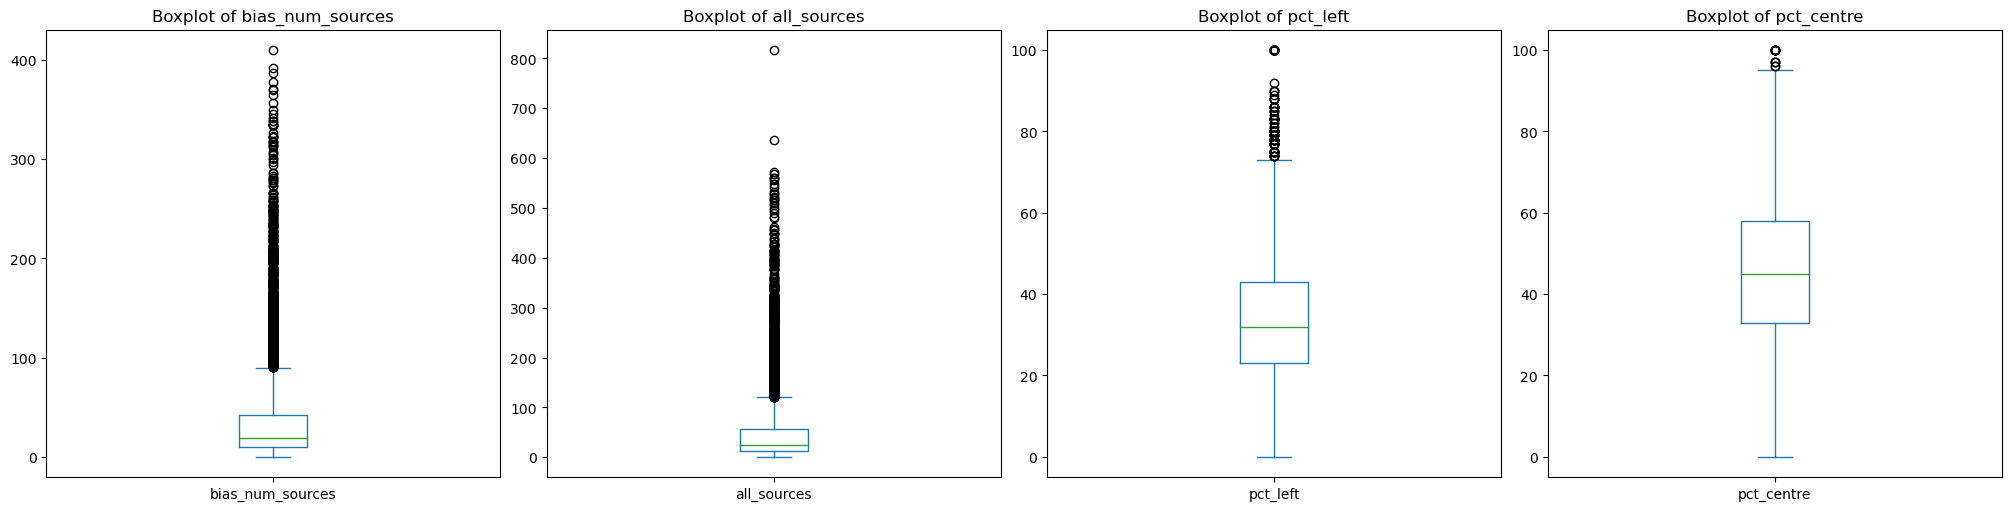

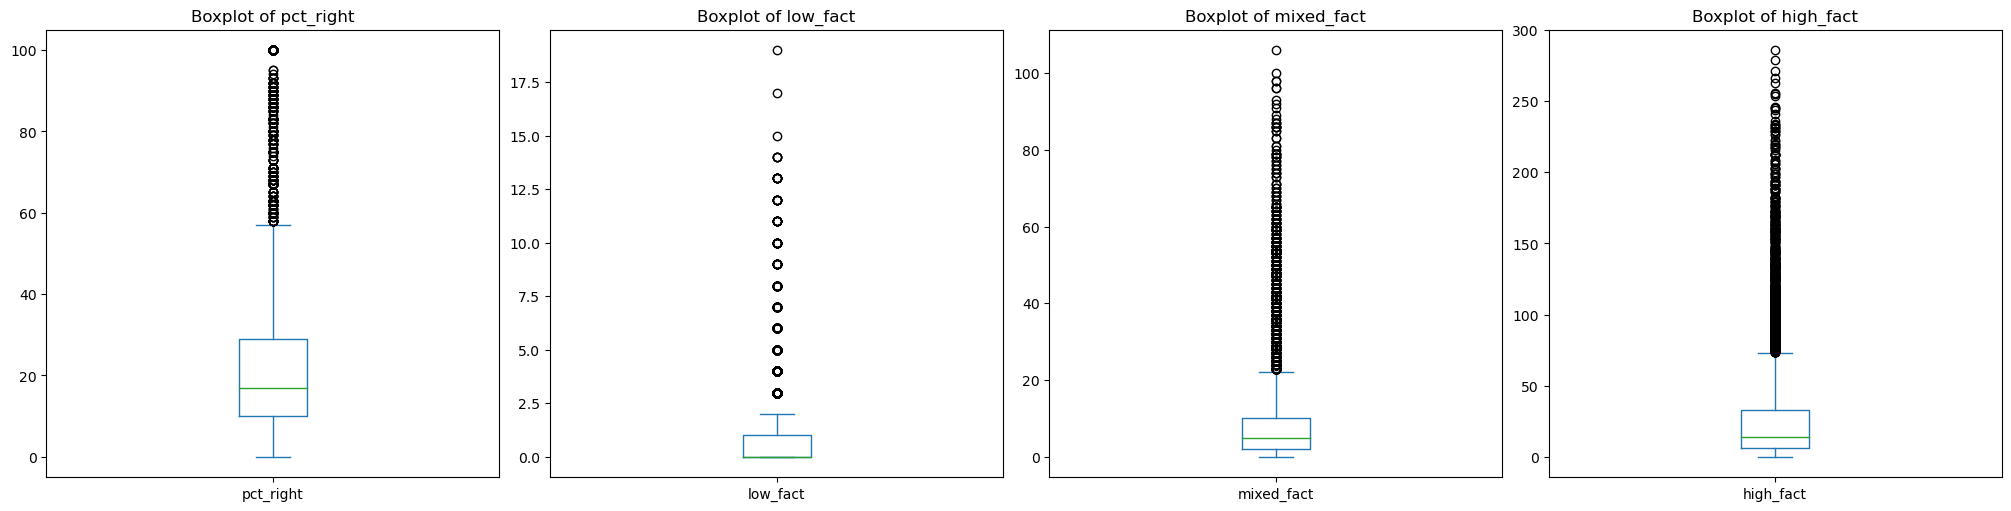

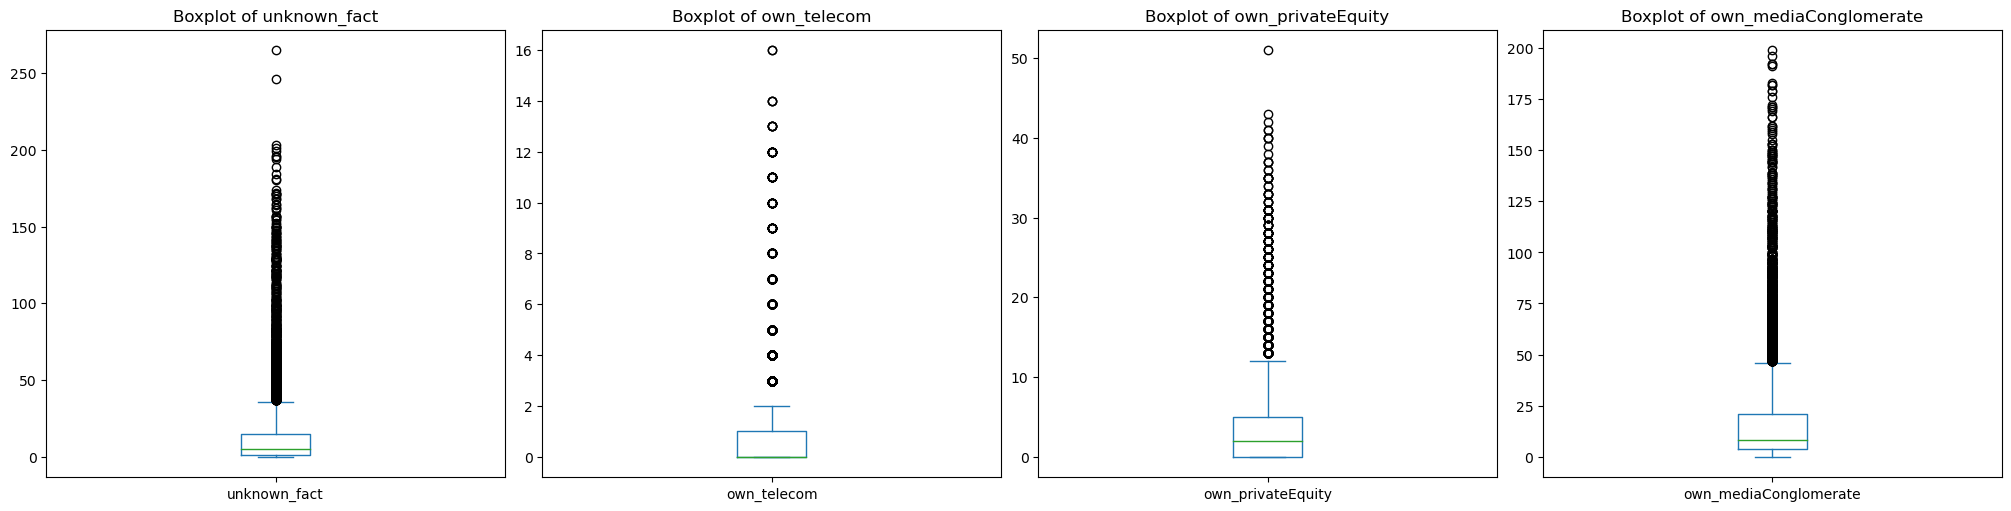

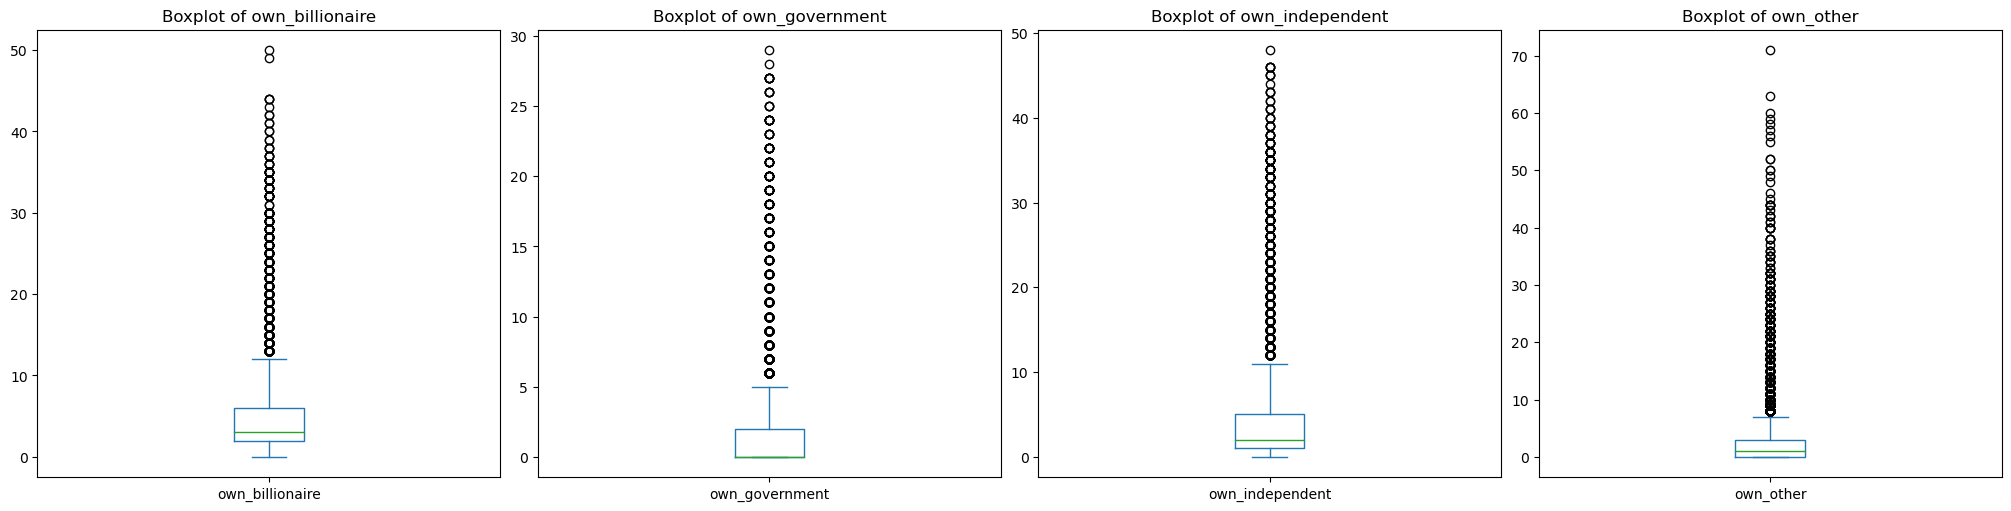

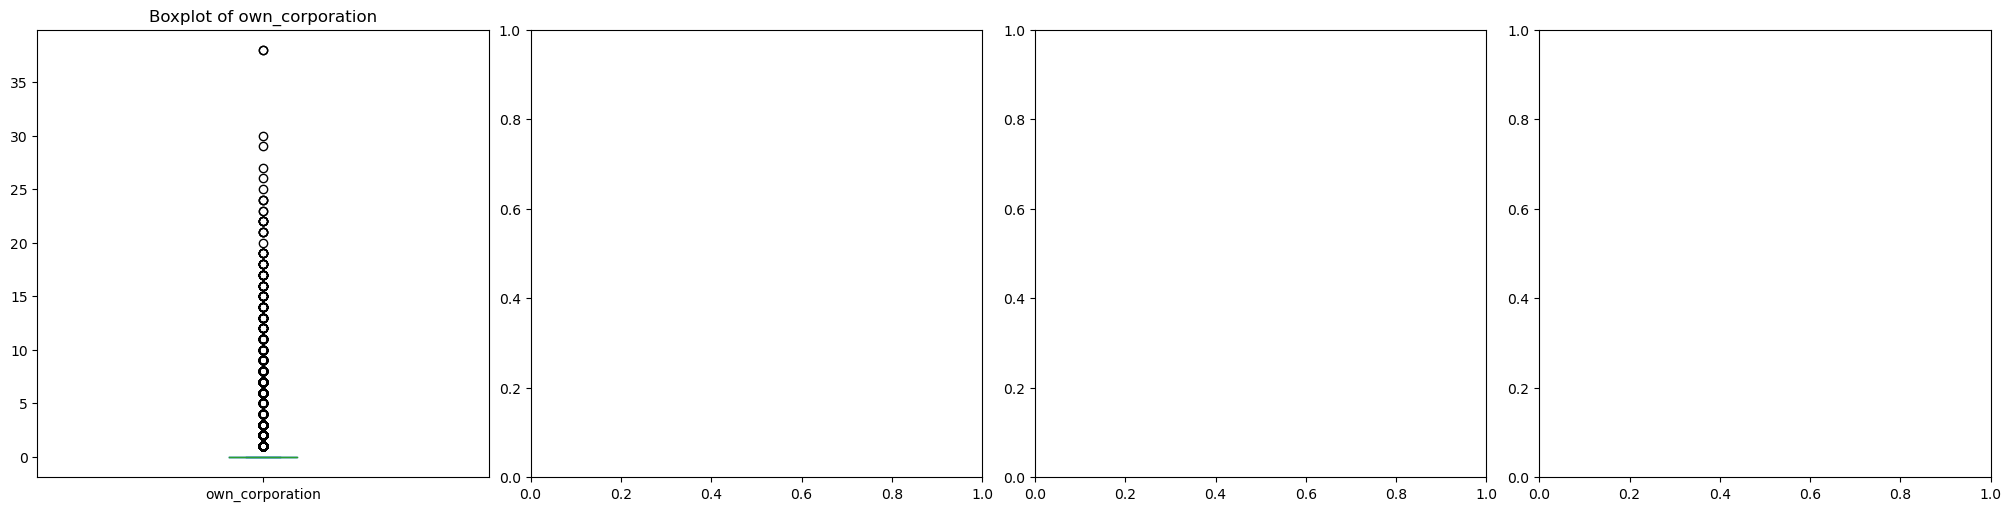

In [31]:
numericas = ground_news_df.select_dtypes(include='number')
# Eliminamos unas categóricas que aquí solo nos despistarán:
numericas.drop(["top_story", "breaking_story", "highlighted_blindspot"], axis = 1, inplace = True)
cols_numericas = numericas.columns

# Desired dimensions for each subplot
subplot_width = 5
subplot_height = 5

# Iterate over the columns in steps of 4 since we want 4 plots per row
for i in range(0, len(cols_numericas), 4):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(subplot_width * 4, subplot_height), constrained_layout=True)
    
    # Iterate over all possible subplot positions in the row (0 to 3)
    for j in range(4):
        ax_index = i + j  # Calculate the actual column index
        
        # If the current index is within the range of columns we have
        if ax_index < len(cols_numericas):
            col = cols_numericas[ax_index]
            numericas[col].plot(kind='box', ax=axs[j])
            axs[j].set_title(f'Boxplot of {col}')
        else:
            # Si no pongo esto como "true", el último gráfico me sale a diferente tamaño, haga lo que haga.
            axs[j].set_visible(True)

    plt.show()

De los boxplots anteriores, constatamos de forma visual como efectivamente para todas las variables bastantes, muchos o muchísimos outliers (para la que menos, para "pct_centre").

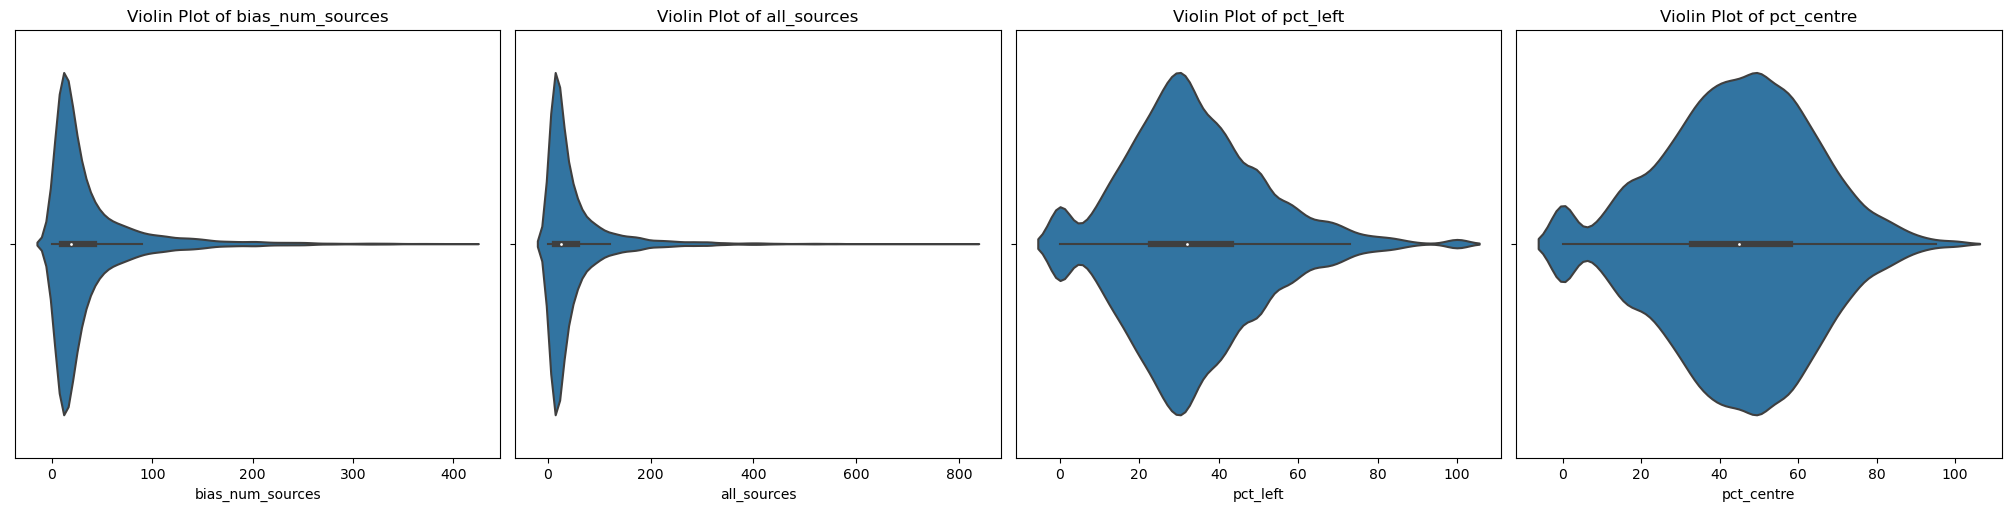

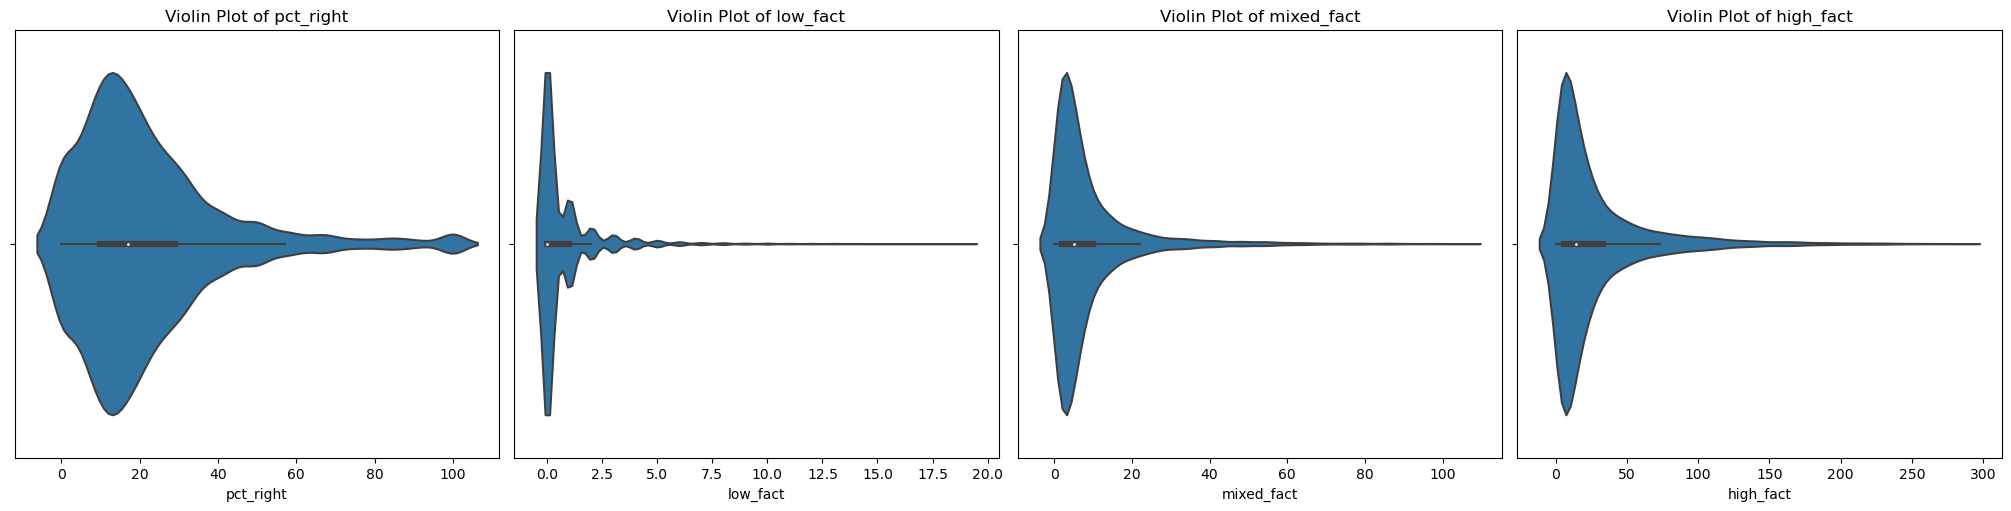

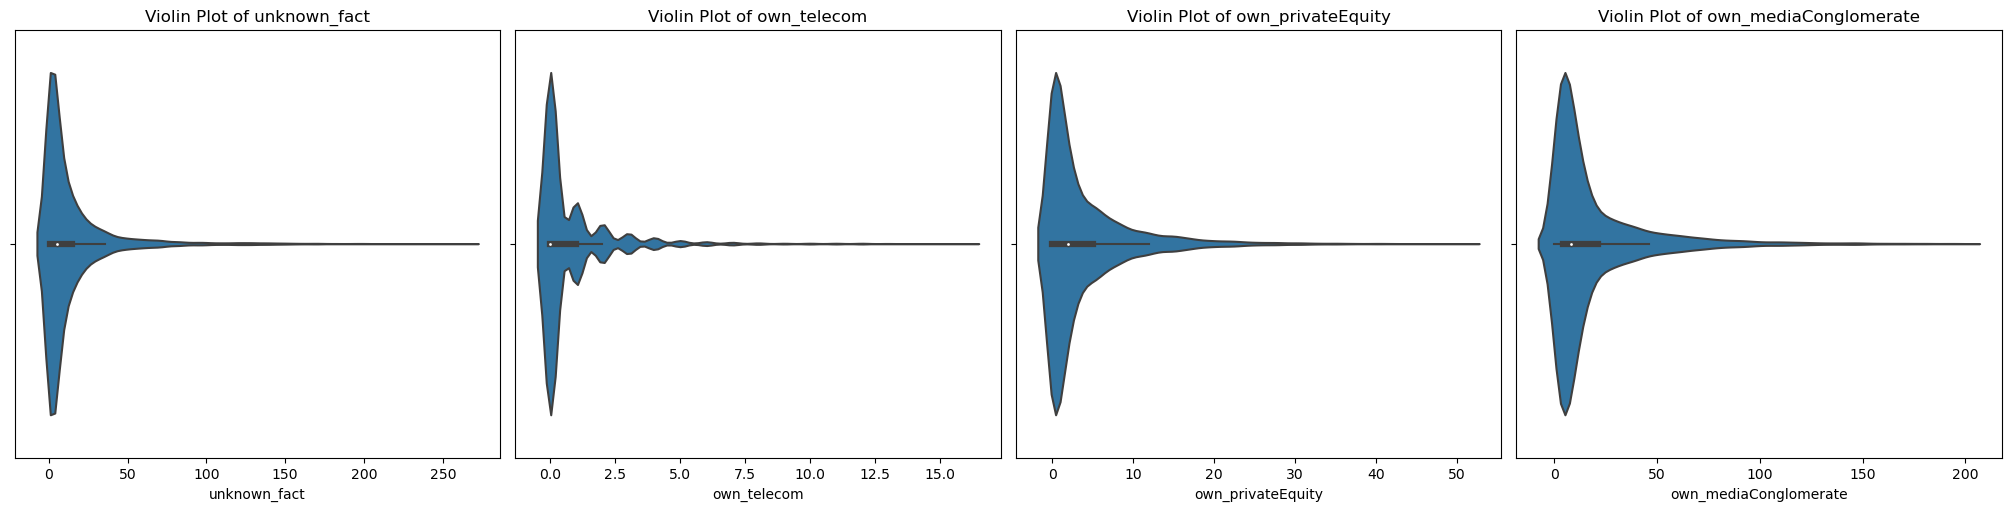

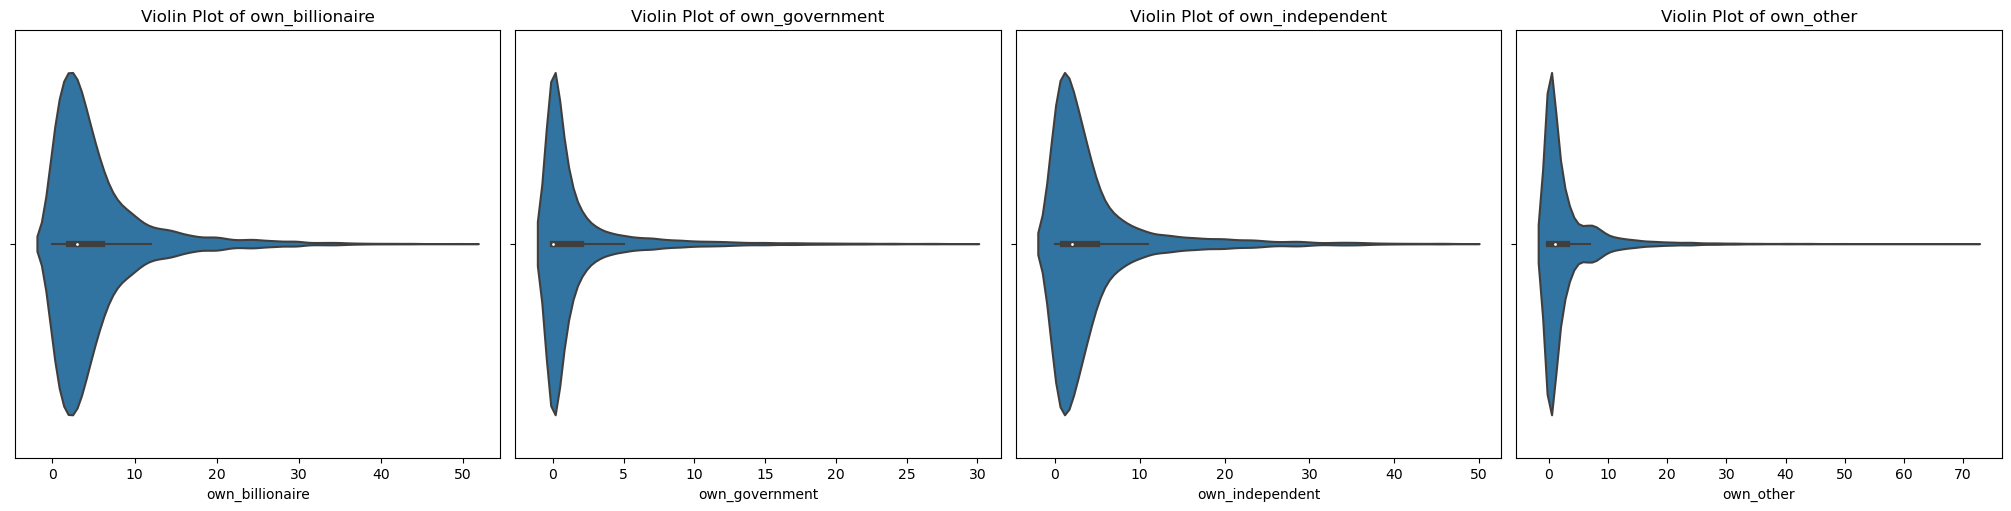

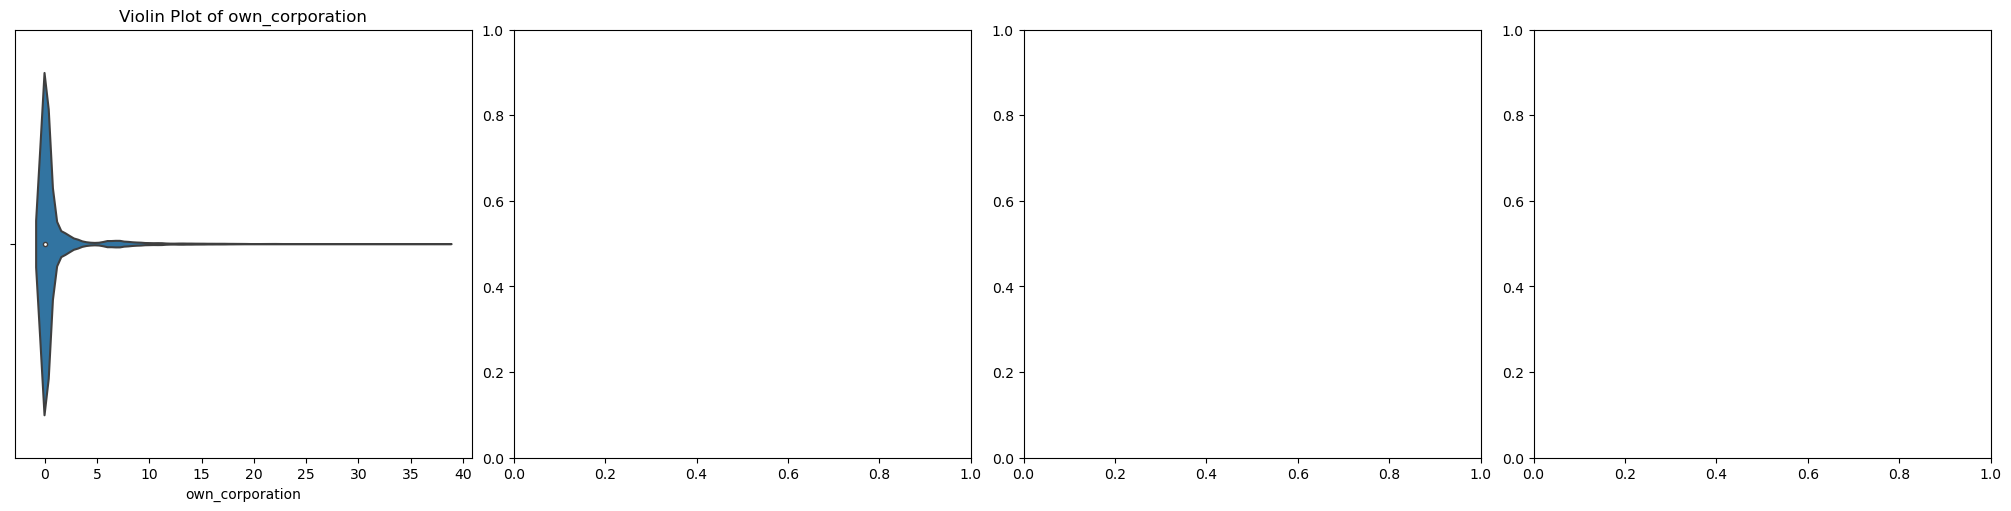

In [32]:
# Usamos la misma variable "cols_numericas" de antes.

# Always create plots with 4 subplots per row
for i in range(0, len(cols_numericas), 4):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), constrained_layout=True)
    
    # Ensure axs is always an array for consistent access
    axs = axs.flatten()
    
    for j in range(4):
        if i + j < len(cols_numericas):  # Check if the column exists
            col = cols_numericas[i + j]
            sns.violinplot(x=numericas[col], ax=axs[j])  # Plot violin plot
            axs[j].set_title(f'Violin Plot of {col}')
        else:
            # Si no pongo esto como "true", el último gráfico me sale a diferente tamaño, haga lo que haga.
            axs[j].set_visible(True)

    plt.show()

En general, en diverso grado, las diferentes variables tienen un sesgo, "skewness", hacia la derecha.

Visualmente, ninguna sigue una distribución gaussiana salvo, tal vez, "pct_centre". Habría que comprobarlo mediante el test de Shapiro-Wilk.

In [33]:
gaussian_columns = []
# Test de normalidad de Shapiro-Wilk
for column in numericas.columns:
    print(column)
    stat, p = shapiro(numericas[column])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:  # Con nivel de significación 0,05: si p está por encima de 0,05 probablemente SÍ tenemos distribución gaussiana (a.k.a. normal).
        gaussian_columns.append(column)
        print('Probably Gaussian\n')
    else:
        print('Probably not Gaussian\n')  # Con nivel de significación 0,05: si p está por debajo de 0,05 probablemente NO tenemos distribución normal o gaussiana.
    # Nota: ejemplo adaptado de:  https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

bias_num_sources
stat=0.652, p=0.000
Probably not Gaussian

all_sources
stat=0.629, p=0.000
Probably not Gaussian

pct_left
stat=0.974, p=0.000
Probably not Gaussian

pct_centre
stat=0.992, p=0.000
Probably not Gaussian

pct_right
stat=0.835, p=0.000
Probably not Gaussian

low_fact
stat=0.514, p=0.000
Probably not Gaussian

mixed_fact
stat=0.648, p=0.000
Probably not Gaussian

high_fact
stat=0.689, p=0.000
Probably not Gaussian

unknown_fact
stat=0.584, p=0.000
Probably not Gaussian

own_telecom
stat=0.547, p=0.000
Probably not Gaussian

own_privateEquity
stat=0.698, p=0.000
Probably not Gaussian

own_mediaConglomerate
stat=0.671, p=0.000
Probably not Gaussian

own_billionaire
stat=0.742, p=0.000
Probably not Gaussian

own_government
stat=0.536, p=0.000
Probably not Gaussian

own_independent
stat=0.658, p=0.000
Probably not Gaussian

own_other
stat=0.566, p=0.000
Probably not Gaussian

own_corporation
stat=0.379, p=0.000
Probably not Gaussian



C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


También numéricamente, vemos que ninguna de las variables parece seguir una distribución gaussiana. Saltemos ahora de las variables numéricas a las que son "objects" o strings, que como veremos nos servirán para generar una serie de variables categóricas que complementarán las que ya hay en el dataframe original "ground_news_df".

### Strings/objects

Mostremos ahora solamente los campos que corresponen a objects/strings:

In [34]:
objects = ground_news_df.select_dtypes(include=['object'])
objects

snapshot_date                                              title  \
0     20220222033957  House of Commons passes Emergencies Act motion...   
1     20220222033957  Putin orders forces to ‘maintain peace’ in eas...   
2     20220222033957  Putin recognizes separatist "republics" in Ukr...   
3     20220222033957       59 killed in gold mine blast in Burkina Faso   
4     20220222033957  Russia's Putin has broken international law, B...   
...              ...                                                ...   
9164  20230213222432  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165  20231227031355  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166  20220405132025  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167  20220223050905  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168  20230731140629  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  \
0     https://ground.news/article/house-of-commons-p...   
1     https://ground.news/article/putin-orders-force...   
2     https://ground.news/article/putin-recognizes-s...   
3     https://ground.news/article/59-killed-in-gold-...   
4     https://ground.news/article/boris-johnson-says...   
...                                                 ...   
9164  https://ground.news/article/magic-mikes-last-d...   
9165  https://ground.news/article/missing-vladimir-p...   
9166  https://ground.news/article/no-tallywhacker-re...   
9167  https://ground.news/article/trump-on-putin-pla...   
9168  https://ground.news/article/scientists-discove...   

                                            description        place  \
0     The House of Commons has passed a motion to ap...       Ottawa   
1     International leaders have strongly criticized...       Moscow   
2     Russian President Vladimir Putin has told his ...       Moscow   
3     A strong explosion near a gold mining site in ...  Ouagadougou   
4     Russian President Vladimir Putin's recognition...       London   
...                                                 ...          ...   
9164  The third installment in the “Magic Mike” seri...  Los Angeles   
9165  Jailed Kremlin critic Alexei Navalny has been ...       Russia   
9166  Rep. Madison Cawthorn (R-NC) used his time on ...   Washington   
9167  Former President Trump on Tuesday called Russi...   Washington   
9168  Virgin births may sound biblical, but research...    Cambridge   

                                                subject  \
0     ['Protestors', 'Justin Trudeau', 'US & Canada'...   
1     ['Europe', 'Military', 'International', 'Polit...   
2     ['Europe', 'Troops', 'Military', 'Internationa...   
3     ['International', 'Africa', 'Gold', 'Ouagadoug...   
4     ['Europe', 'Boris Johnson', 'International', '...   
...                                                 ...   
9164  ['Entertainment', 'Movie', 'Celebrity', 'Super...   
9165  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...   
9166  ['Politics', 'Videos', 'North America', 'Madis...   
9167  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...   
9168  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...   

                                       coverage_profile  
0     This news story only has <b>20% right</b> poli...  
1     This news story only has <b>29% right</b> poli...  
2     This news story has <b>30% left</b> political ...  
3                             Blindspot: Only 13% Right  
4     This news story only has <b>17% center</b> pol...  
...                                                 ...  
9164  This news story only has <b>4% right</b> polit...  
9165  This news story only has <b>24% right</b> poli...  
9166                                Blindspot: 0% Right  
9167                          Blindspot: Only 19% Right  
9168  This news story only has <b>29% right & center...  

[9169 rows x 7 columns]

En estas columnas del dataframe tenemos:
    
"snapshot_date": un string que en formato yyyymmddhhmmss nos dice el momento en que el Internet Archive guardó la web de interés.
    
"title": el título de la noticia.
    
"url": la URL reconstruida que lleva a la noticia concreta en la web de Ground News. En caso de necesidad, se puede recuperar ahí más información.
    
"description": un breve resumen de 1-3 frases sobre la noticia.
    
"place": lugar del cual sale o en el cual se enmarca la noticia.
    
"subject": en formato string, una lista de temas sobre los cuales versa la noticia.
    
"coverage_profile": en formato string, una declaración de la web "Ground News" sobre el sesgo (izquierda/derecha) que tiene cada noticia.

    
De todos estos campos, para la labor de sacar patrones sobre quién y cómo cubre las noticias, potencialmente podemos descartar: "snapshot_date", "url", "coverage_profile" (ya que queda implícito en las métricas que veremos a continuación).

Los "objects"/strings de un registro concreto, más en detalle:

In [35]:
for column in objects.iloc[2,:]:
    print(column)

20220222033957
Putin recognizes separatist "republics" in Ukraine in likely prelude to war
https://ground.news/article/putin-recognizes-separatist-republics-in-ukraine-in-likely-prelude-to-war_3c295d
Russian President Vladimir Putin has told his German and French counterparts that he intends to soon sign a decree recognizing two breakaway "republics" in eastern Ukraine as independent, the Kremlin announced on Monday. Putin is expected to give a televised address imminently.
Moscow
['Europe', 'Troops', 'Military', 'International', 'European Union', 'sanctions', 'Politics', 'Kremlin', 'Vladimir Putin', 'Moscow, Russia', 'Washington DC', 'Kyiv']
This news story has <b>30% left</b> political bias coverage


#### Creación de nuevos campos a partir de objects/strings

Antes de eliminar algunas de esas columnas, nos puede interesar tomar varias acciones:
    
a) Extraer algunas categóricas u ordinales a partir del "snapshot_date" (para eso, lo transformaremos en un objeto "datetime").
    
b) Extraer los temas de cada una de las noticias. Puede ser inmanejable si intentamos extraer todos, pero, ¿tal vez crear binarias de las más importantes?

c) La ubicación.

d) Analizar el tono del titular y/o de la descripción de la noticia (análisis de sentimiento).

#### Creación de nuevas categóricas a partir de "snapshot_date"

Transformación de tiempo a objeto "datetime"

In [36]:
# Convert 'snapshot_date' to datetime format
ground_news_df['snapshot_date'] = pd.to_datetime(ground_news_df['snapshot_date'], format='%Y%m%d%H%M%S')

# Ahora, el "snapshot_date" es un objeto tipo "datetime":
print(ground_news_df.dtypes)

snapshot_date            datetime64[ns]
title                            object
url                              object
bias_num_sources                float64
all_sources                     float64
description                      object
place                            object
subject                          object
pct_left                        float64
pct_centre                      float64
pct_right                       float64
coverage_profile                 object
low_fact                        float64
mixed_fact                      float64
high_fact                       float64
unknown_fact                    float64
own_telecom                     float64
own_privateEquity               float64
own_mediaConglomerate           float64
own_billionaire                 float64
own_government                  float64
own_independent                 float64
own_other                       float64
own_corporation                 float64
top_story                       float64


Creación de categóricas "es_finde", "month" y "year" a partir del objeto "datetime".

In [37]:
def es_finde(datetime):  # Un objeto "datetime", que viene de la columna 'status_published'
    day = datetime.dayofweek   #  Nota mental: añadir .dt. solo es necesario aplicándolo a una serie.
    hour = datetime.hour
    if day in [5, 6]:  # 5 y 6 corresponden a sábado y domingo. 
        return 1  # Es fin de semana
    elif day == 4 and hour >= 18:  # Es viernes por la tarde, así que es finde.
        return 1  # Es fin de semana.
    else:
        return 0  # No es finde.

# Ensure that 'status_published' or similar column containing datetime objects is used
ground_news_df['es_finde'] = ground_news_df['snapshot_date'].apply(es_finde)

In [38]:
ground_news_df['month'] = ground_news_df['snapshot_date'].dt.month

In [39]:
ground_news_df['year'] = ground_news_df['snapshot_date'].dt.year

### Extracción de las diversas temáticas y de ubicaciones geográficas

A partir del campo "subject", hagámonos una idea de los temas que aparercen y los ordenamos por número de apariciones. Ejemplo de qué encontramos en ese campo para una de las líneas:

In [40]:
print(ground_news_df.iloc[9057, 7])

['Europe', 'European Economy', 'US Economy', 'Middle East', 'Houthi Rebels', 'Asia', 'Trade', 'Oceania', 'Canadian Economy', 'Asian Economy', 'New Zealand Economy', 'Middle East Economy', 'Australia Economy', 'White House', 'UK Economy', 'Yemen', 'United States', 'Australia', 'New Zealand', 'Canada', 'United Kingdom']


In [41]:
import pandas as pd
import ast
from collections import Counter

Definimos una función (que luego volveremos a usar) para contar el número de "temas" que aparecen en la columna "subject".

In [42]:
def count_items_in_column(df, column_name):
    """
    Takes a DataFrame and a column name where each row contains a list of items (as a string or actual list).
    Counts the occurrences of each item and returns a DataFrame sorted by count in descending order.
    
    :param df: DataFrame to process.
    :param column_name: Column in DataFrame containing the item lists.
    :return: DataFrame with items and their counts, sorted by count.
    """
    # Ensure all entries in the column are lists
    try:
        df[column_name] = df[column_name].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
    except ValueError:
        print(f"Conversion error: Check the format of '{column_name}' strings.")

    # Flatten the list of lists into a single list
    all_items = []
    for item_list in df[column_name]:
        if isinstance(item_list, list):  # Ensure it's actually a list
            all_items.extend(item_list)
        else:
            print(f"Error: Entry not a list. Check the data: {item_list}")

    # Use Counter to count occurrences of each item
    item_counts = Counter(all_items)

    # Convert the Counter object into a DataFrame
    items_rank = pd.DataFrame(item_counts.items(), columns=[column_name.capitalize(), 'Count'])

    # Sort the DataFrame by 'Count' to see the most common items first
    items_rank = items_rank.sort_values(by='Count', ascending=False).reset_index(drop=True)

    return items_rank

In [43]:
subjects_rank = count_items_in_column(objects, "subject")

In [44]:
subjects_rank

Subject  Count
0                  Politics   5029
1               US Politics   3410
2             North America   2521
3                    Europe   1775
4               US & Canada   1636
...                     ...    ...
3133    Deerfield, Illinois      1
3134      Chandler, Arizona      1
3135     Affirmative Action      1
3136           Latah County      1
3137  Franklin County, Ohio      1

[3138 rows x 2 columns]

Lo anterior nos da una lista muy larga, en la cual hay temas de muy poca relevancia o que, al menos, aparecen muy poco (alargando la lista innecesariamente). Además, hay una sobrerrepresentación de ubicaciones geográficas, que abordaremos luego. ¿Qué hacemos con todo esto?

Para aclarar un poco el panorama, eliminaremos de esta lista todo lo que sean ubicaciones geográficas, y así nos quedaremos realmente solo con temáticas. Las ubicaciones las consideraremos aparte.

Por otra parte, consolidaremos toda la información que podamos obtener sobre ubicaciones geográficas (tanto de "place", como "subject", "title" y "description" en una sola columna que se refiera a las ubicaciones.

#### Interludio: extracción de ubicaciones geográficas

Para identificar nombres de ubicaciones geográficas y/o enter geopolíticos, usaremos el paquete "spacy":

In [45]:
import spacy
import re

# Modelo pre-entrenado de spaCy's (versión reducida)
#nlp = spacy.load("en_core_web_sm")
# Modelo pre-entrenado de "spacy", versión larga:
nlp = spacy.load("en_core_web_lg")

Como podemos ver, en los temas, o sea el campo "subject" de cada noticia hay elementos geográficos (lo mismo pasará con los títulos y descripciones de las noticias):

In [46]:

print((str(ground_news_df.subject[1])))


['Europe', 'Military', 'International', 'Politics', 'Kremlin', 'NATO', 'Volodymyr Zelenskiy', 'Vladimir Putin', 'Moscow, Russia', 'Kyiv', 'Ukraine']


Mediante una función a tal efecto, extraemos ubicaciones geográficas para cada campo susceptible de contenerlas (aparte de "place"). Por claridad, lo hago por pasos:

In [47]:
def identify_geonames(text):
    # Attempt to convert input to a string if it's not already one
    try:
        # If text is a list, dictionary, etc., this will convert it to a string
        text_str = str(text)
    except Exception as e:
        print(f"Error converting input to string: {e}")
        return []  # Return empty list if conversion fails

    # Preprocess the string to remove brackets and single quotes
    cleaned_text = re.sub(r"[\[\]']", "", text_str)
    doc = nlp(cleaned_text)
    # Collect words identified as GPE (GeoPolitical Entity) or LOC (Location)
    geonames = [ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]
    return geonames

Extraemos la información geográfica:

In [48]:
# ¿Menciona el título alguna ubicación...?
ground_news_df['geo_names_title'] = ground_news_df['title'].apply(identify_geonames)

# ¿Y la descripción?
ground_news_df['geo_names_description'] = ground_news_df['description'].apply(identify_geonames)

# ¿Y el tema...?
ground_news_df['geo_names_subject'] = ground_news_df['subject'].apply(identify_geonames)

Consolidamos la información generada, reuniéndola en un solo campo y eliminando duplicados mediante una función creada a tal efecto, "consolidate_and_deduplicate_per_row".

In [49]:
def consolidate_and_deduplicate(locations):
    consolidated = []
    for location in locations:
        if location not in consolidated:
            consolidated.append(location)
    return consolidated

# Consolidar y des-duplicar los nombres geográficos de cada columnaa partir de los campos creados
def consolidate_and_deduplicate_per_row(row):
    # Nota: combinamos los campos generados arriba, así como el preexistente, "Place":
    combined_locations = row['geo_names_title'] + row['geo_names_description'] + row['geo_names_subject'] + [row['place']]
    # Add data from 'test' DataFrame if needed, assuming matching indices
    # This step might need adjustment based on how you intend to integrate 'test' DataFrame's data
    # combined_locations += test.loc[row.name, 'geo_names_subject'] if row.name in test.index else []
    
    return consolidate_and_deduplicate(combined_locations)

In [50]:
ground_news_df['consolidated_geo_names'] = ground_news_df.apply(consolidate_and_deduplicate_per_row, axis=1)
ground_news_df

snapshot_date                                              title  \
0    2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1    2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2    2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3    2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4    2022-02-22 03:39:57  Russia's Putin has broken international law, B...   
...                  ...                                                ...   
9164 2023-02-13 22:24:32  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165 2023-12-27 03:13:55  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166 2022-04-05 13:20:25  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167 2022-02-23 05:09:05  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168 2023-07-31 14:06:29  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  bias_num_sources  \
0     https://ground.news/article/house-of-commons-p...              15.0   
1     https://ground.news/article/putin-orders-force...              76.0   
2     https://ground.news/article/putin-recognizes-s...              46.0   
3     https://ground.news/article/59-killed-in-gold-...              23.0   
4     https://ground.news/article/boris-johnson-says...              18.0   
...                                                 ...               ...   
9164  https://ground.news/article/magic-mikes-last-d...              91.0   
9165  https://ground.news/article/missing-vladimir-p...             210.0   
9166  https://ground.news/article/no-tallywhacker-re...               9.0   
9167  https://ground.news/article/trump-on-putin-pla...              27.0   
9168  https://ground.news/article/scientists-discove...              24.0   

      all_sources                                        description  \
0            27.0  The House of Commons has passed a motion to ap...   
1            88.0  International leaders have strongly criticized...   
2            57.0  Russian President Vladimir Putin has told his ...   
3            29.0  A strong explosion near a gold mining site in ...   
4            32.0  Russian President Vladimir Putin's recognition...   
...           ...                                                ...   
9164        113.0  The third installment in the “Magic Mike” seri...   
9165        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
9166          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
9167         28.0  Former President Trump on Tuesday called Russi...   
9168         34.0  Virgin births may sound biblical, but research...   

            place                                            subject  \
0          Ottawa  ['Protestors', 'Justin Trudeau', 'US & Canada'...   
1          Moscow  ['Europe', 'Military', 'International', 'Polit...   
2          Moscow  ['Europe', 'Troops', 'Military', 'Internationa...   
3     Ouagadougou  ['International', 'Africa', 'Gold', 'Ouagadoug...   
4          London  ['Europe', 'Boris Johnson', 'International', '...   
...           ...                                                ...   
9164  Los Angeles  ['Entertainment', 'Movie', 'Celebrity', 'Super...   
9165       Russia  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...   
9166   Washington  ['Politics', 'Videos', 'North America', 'Madis...   
9167   Washington  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...   
9168    Cambridge  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...   

      pct_left  pct_centre  pct_right  \
0         33.0        47.0       20.0   
1         33.0        38.0       29.0   
2         30.0        31.0       39.0   
3         52.0        35.0       13.0   
4         50.0        17.0       33.0   
...        ...         ...        ...   
9164      20.0        76.0        4.0   
9165      31.0        45.0       24.0   
9166     100.0         0.0        0.0 

Si nos fijamos, en efecto vemos que se han combinado. Ya podemos borrar los campos intermedios que hemos generado ("geo_names_title", "geo_names_description", y "geo_names_subject", y también "place", que era la columna original que mencionaba la ubicación):

In [51]:
ground_news_df.head(40)

snapshot_date                                              title  \
0  2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1  2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2  2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3  2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4  2022-02-22 03:39:57  Russia's Putin has broken international law, B...   
5  2022-02-22 03:39:57  Colombia’s highest court rules to decriminaliz...   
6  2022-02-22 03:39:57  U.N. chief believes Russia has violated Ukrain...   
7  2022-02-22 03:39:57  US cautious on whether Russian troops to Donba...   
8  2022-02-22 03:39:57  Australia plane had 'right' to watch China nav...   
9  2022-02-22 03:39:57  Emergencies Act still needed, Prime Minister J...   
10 2022-02-22 03:39:57  Ukraine wants peace but won't give up its land...   
11 2022-02-22 03:39:57  Saudi Arabia: 16 hurt in airport drone attack ...   
12 2022-02-22 03:39:57  Israeli inquiry sees no indication of unlawful...   
13 2022-02-22 03:39:57  Baltics call for swift EU sanctions on Russia ...   
14 2022-02-22 03:39:57       Mexico City legislature may ban bullfighting   
15 2022-02-22 03:39:57  California trans child molester Hannah Tubbs g...   
16 2022-02-22 03:39:57  Idaho passes bill prohibiting so-called 'ballo...   
17 2022-02-23 05:09:05  Partygate questionnaire leaked as Boris waits ...   
18 2022-02-23 05:09:05  Chicago to follow state by lifting mask mandat...   
19 2022-02-23 05:09:05  Florida GOP 'Don't Say Gay' bill advances in H...   
20 2022-02-23 05:09:05  65 percent of rural voters view Democratic Par...   
21 2022-02-23 05:09:05  Biden announces first tranche of Russia sancti...   
22 2022-02-23 05:09:05  Biden says mineral supply chain actions will h...   
23 2022-02-23 05:09:05  Former Dolphins head coach Brian Flores says r...   
24 2022-02-23 05:09:05  Biden sends troops to Baltics, F-35s to NATO's...   
25 2022-02-23 05:09:05  Capitol Police ask DC National Guard for assis...   
26 2022-02-23 05:09:05  2 deputies jailed in shooting death of Louisia...   
27 2022-02-23 05:09:05  Mickelson apologises for 'reckless' comments o...   
28 2022-02-23 05:09:05  Ahmaud Arbery's killers convicted on all feder...   
29 2022-02-23 05:09:05  AT&T is shutting down its 3G network. Here's h...   
30 2022-02-23 05:09:05  U.S. top diplomat Blinken cancels meeting with...   
31 2022-02-23 05:09:05  Toronto MP thinks a Freedom Convoy term is cal...   
32 2022-02-24 02:44:58  Jason Kenny: Great Britain's most successful O...   
33 2022-02-24 02:44:58  Ukraine’s president in plea for peace as he wa...   
34 2022-02-24 02:44:58   Canada’s Trudeau Revokes Use of Emergency Powers   
35 2022-02-24 02:44:58  Russia says Donbas separatists ask Putin for m...   
36 2022-02-24 02:44:58  Queen Elizabeth II holds weekly audience with ...   
37 2022-02-24 02:44:58  At least five blasts heard in separatist-held ...   
38 2022-02-24 02:44:58  UK government believes Wuhan lab leak most lik...   
39 2022-02-24 02:44:58   Ukraine's Parliament approves state of emergency   

                                                  url  bias_num_sources  \
0   https://ground.news/article/house-of-commons-p...              15.0   
1   https://ground.news/article/putin-orders-force...              76.0   
2   https://ground.news/article/putin-recognizes-s...              46.0   
3   https://ground.news/article/59-killed-in-gold-...              23.0   
4   https://ground.news/article/boris-johnson-says...              18.0   
5   https://ground.news/article/colombias-highest-...              31.0   
6   https://ground.news/article/un-chief-believes-...               9.0   
7   https://ground.news/article/us-cautious-on-whe...               4.0   
8   https://ground.news/article/australia-plane-ha...               4.0   
9   https://ground.news/article/emergencies-act-st...              38.0   
10  https://ground.news/ar

In [55]:
# INCLUIR NUMBER LOCATIONS

ground_news_df.drop(columns=["geo_names_title", "geo_names_description", "geo_names_subject", "place"], inplace=True)
ground_news_df

snapshot_date                                              title  \
0    2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1    2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2    2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3    2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4    2022-02-22 03:39:57  Russia's Putin has broken international law, B...   
...                  ...                                                ...   
9164 2023-02-13 22:24:32  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165 2023-12-27 03:13:55  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166 2022-04-05 13:20:25  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167 2022-02-23 05:09:05  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168 2023-07-31 14:06:29  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  bias_num_sources  \
0     https://ground.news/article/house-of-commons-p...              15.0   
1     https://ground.news/article/putin-orders-force...              76.0   
2     https://ground.news/article/putin-recognizes-s...              46.0   
3     https://ground.news/article/59-killed-in-gold-...              23.0   
4     https://ground.news/article/boris-johnson-says...              18.0   
...                                                 ...               ...   
9164  https://ground.news/article/magic-mikes-last-d...              91.0   
9165  https://ground.news/article/missing-vladimir-p...             210.0   
9166  https://ground.news/article/no-tallywhacker-re...               9.0   
9167  https://ground.news/article/trump-on-putin-pla...              27.0   
9168  https://ground.news/article/scientists-discove...              24.0   

      all_sources                                        description  \
0            27.0  The House of Commons has passed a motion to ap...   
1            88.0  International leaders have strongly criticized...   
2            57.0  Russian President Vladimir Putin has told his ...   
3            29.0  A strong explosion near a gold mining site in ...   
4            32.0  Russian President Vladimir Putin's recognition...   
...           ...                                                ...   
9164        113.0  The third installment in the “Magic Mike” seri...   
9165        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
9166          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
9167         28.0  Former President Trump on Tuesday called Russi...   
9168         34.0  Virgin births may sound biblical, but research...   

                                                subject  pct_left  pct_centre  \
0     ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0        47.0   
1     ['Europe', 'Military', 'International', 'Polit...      33.0        38.0   
2     ['Europe', 'Troops', 'Military', 'Internationa...      30.0        31.0   
3     ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0        35.0   
4     ['Europe', 'Boris Johnson', 'International', '...      50.0        17.0   
...                                                 ...       ...         ...   
9164  ['Entertainment', 'Movie', 'Celebrity', 'Super...      20.0        76.0   
9165  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...      31.0        45.0   
9166  ['Politics', 'Videos', 'North America', 'Madis...     100.0         0.0   
9167  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...      63.0        18.0   
9168  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...      42.0        29.0   

      pct_right                                   coverage_profile  low_fact  \
0          20.0  This news story only has <b>20% right</b> poli...       1.0   
1          29.0  This news story only has <b>29% right</b> poli...       2.0   
2          39.0  This news story has <b>30% left</b> politi

Contamos y rankeamos de nuevo, mediante la función creada antes, ahora las ubicaciones geográficas que hemos consolidado en el campo "consolidated_geo_names". Veremos que contiene grafías diferentes de un mismo país (p.ej. United States, US...), y algunas entidades supranacionales (Europe, North America).

In [64]:
rank_locations = count_items_in_column(ground_news_df, 'consolidated_geo_names')
rank_locations

Consolidated_geo_names  Count
0             North America   2513
1             United States   2220
2                        US   1809
3                    Europe   1789
4             Washington DC   1592
...                     ...    ...
2448               Barmouth      1
2449           Union Berlin      1
2450                 Bochum      1
2451            Montpellier      1
2452        Franklin County      1

[2453 rows x 2 columns]

In [68]:
rank_locations.head(40)

Consolidated_geo_names  Count
0           North America   2513
1           United States   2220
2                      US   1809
3                  Europe   1789
4           Washington DC   1592
5              Washington   1585
6                    Asia   1064
7                    U.S.    993
8                  Russia    685
9                New York    629
10             California    598
11            Middle East    549
12                Ukraine    541
13                 Moscow    495
14          New York City    442
15                England    437
16                 London    399
17                   Kyiv    356
18                Florida    347
19                 Israel    330
20   Middle East Politics    299
21                  Texas    296
22                  China    280
23               Americas    267
24                 Canada    265
25            Los Angeles    227
26      the United States    218
27                Beijing    213
28                Georgia    198
29                   Gaza    182
30                 Africa    157
31          International    143
32          Latin America    139
33                Oceania    138
34                     UK    136
35          San Francisco    135
36         United Kingdom    134
37           Pennsylvania    130
38                 France    123
39                     NY    121

Las ubicaciones más frecuentes del dataframe anterior las terminaremos convirtiendo en categóricas. Pero antes sigamos con otra cosa: la extracción de los temas más frecuentes que tratan las diferentes noticias. Nos basaremos en el campo "subject", que ya etiqueta las noticias por temas.

Bien, llegados a este punto tenemos dos rankings:
    
a) Un ranking de temas de interés, pero que hemos visto que está muy "contaminado" por temas que en realidad son ubicaciones geográficas. A este le quitaremos a continuación los elementos geográficos y extraeremos los temas de más interés tratados en las noticias recogidas.

b) Un ranking de ubicaciones geográficas.

Filtraremos/trabajaremos un poco más el ranking de temas.

#### Finalmente, ranking de temas de interés (sin elementos geográficos)

Eliminación de elementos geográficos o geopolíticos de la lista de temas:

In [69]:
def process_subject(subject):
    doc = nlp(subject)
    # Initialize an empty list to store non-geographical tokens
    filtered_tokens = []
    # Track if all entities are geographical
    all_geographical = True
    
    for ent in doc.ents:
        # If an entity is a GPE or LOC, remove it from the subject
        if ent.label_ in ["GPE", "LOC"]:
            subject = subject.replace(ent.text, '')
            all_geographical = False

    
    # Remove extra spaces and return processed subject or a flag for removal
    processed_subject = ' '.join(subject.split())
    return processed_subject if not all_geographical or processed_subject != '' else None


Eliminamos los "temas" geográficos. No es perfecto, pero nos ha limpiado mucho el dataframe.

In [70]:
# Process each subject to remove geographical entities
subjects_rank['Processed_Subject'] = subjects_rank['Subject'].apply(process_subject)
subjects_rank

Subject  Count   Processed_Subject
0                  Politics   5029            Politics
1               US Politics   3410            Politics
2             North America   2521                    
3                    Europe   1775                    
4               US & Canada   1636         US & Canada
...                     ...    ...                 ...
3133    Deerfield, Illinois      1                   ,
3134      Chandler, Arizona      1           Chandler,
3135     Affirmative Action      1  Affirmative Action
3136           Latah County      1                    
3137  Franklin County, Ohio      1                   ,

[3138 rows x 3 columns]

In [71]:
subjects_rank

Subject  Count   Processed_Subject
0                  Politics   5029            Politics
1               US Politics   3410            Politics
2             North America   2521                    
3                    Europe   1775                    
4               US & Canada   1636         US & Canada
...                     ...    ...                 ...
3133    Deerfield, Illinois      1                   ,
3134      Chandler, Arizona      1           Chandler,
3135     Affirmative Action      1  Affirmative Action
3136           Latah County      1                    
3137  Franklin County, Ohio      1                   ,

[3138 rows x 3 columns]

Llegados este punto, decido seleccionar unos 20 temas. Para ello, examino los primeras 200-250 líneas del dataframe que contienen el ranking (las últimas palabras de dicho ranking tendrían unas 40 apariciones como tema en las noticias del dataset):

In [75]:
# print(list(subjects_rank_filtered[0:250].Processed_Subject))
original_list = list(subjects_rank[0:250].Processed_Subject)

# Para que aparezca más limpio, se eliminan strings vacíos y comas:
filtered_list = [item for item in original_list if item != '' and item != ',']

print(filtered_list)

['Politics', 'Politics', 'US & Canada', 'Business', 'Politics', 'Republican Party', 'Joe Biden', 'Donald Trump', 'North American Politics', 'Tech', 'European Politics', 'International', 'Asian Politics', 'Economy', 'Military', 'Democratic Party', 'Medical', 'Health', 'Videos', 'Economy', 'Crime', 'Police', 'District of Columbia Politics', 'Science', 'Justice', 'Entertainment', 'Environment', 'Sports', '2024 US Election', 'White House', 'Israeli-Palestinian Conflict', 'Canadian Politics', 'Politics', 'Guns', 'Celebrity', 'United States Economy', 'Coronavirus', 'Ukraine War', 'Vladimir Putin', 'Social Media', 'Hamas', 'North American Economy', 'Immigration', 'Politics', 'Politics', 'Climate Change', 'Money', 'Offbeat', 'Crisis', 'gun violence', 'Transgender', 'United Nations', 'Ron DeSantis', 'Murder', 'Abortion', 'Movies & TV', 'War', 'Travel', 'Biden Administration', 'Twitter', 'Pandemic', 'Elon Musk', 'Politics', 'LGBTQ+', 'US Supreme Court', 'Politics', 'European Economy', 'Departmen

Esto lo he trabajado y curado manualmente fuera del "notebook". He identificado veinte temas principales que tienen una presencia significativa en el dataset. Para cada uno, he repartido los sub-temas relacionados que aparecían en la columna "subject" en generales y controvertidos. De ese trabajo parcialmente manual, he obtenido esta estructura (ver más abajo cada uno de los veinte temas):

In [142]:
subjects_dict = {
    "politics": {
        "general": [
            "Politics", "Politicians", "Election", "White House", "Midterm elections",
            "US Congress", "Senate", "2024 US Election", "Midterm Elections", "Voting"
        ],
        "contentious": [
            "Joe Biden", "Donald Trump", "Ron DeSantis", "Trump", "Biden",
            "Biden Administration", "Impeachment", "Nikki Haley", "Russia Politics", "Ukraine Politics", "Kamala Harris"
        ]
    },
    "social": {
        "general": [
            "Mental Health", "Education", "Water"
        ],
        "contentious": [
            "racism", "Black Lives Matter", "Transgender", "Gender issues", "LGBTQ+", "LGBTQ", "Housing",
            "human rights", "Abortion", "Women's Rights", "Protests", "Protest", "Protestors",
            "Riots", "Immigration", "Refugees"
        ]
    },
    "religion": {
        "general": [
            "Religion"
        ],
        "contentious": [
            "Catholic Church", "Pope Francis", "Islam", "Jewish", "Christian",
            "Islamic", "Judaism", "Christianity"
        ]
    },
    "economy": {
        "general": [
            "Business", "Economy", "Money", "Finance", "Federal Reserve",
            "Inflation", "Stock Markets", "Wall Street", "Interest rates", "Auto",
            "Oil and Gas Sector", "Automotive"
        ],
        "contentious": [
            "Taxes", "Economic Crisis", "Housing"
        ]
    },
    "technology": {
        "general": [
            "Space", "NASA", "Tech", "Tech Companies",
            "Electric Vehicles", "Cryptocurrency", "Technology", "drones"
        ],
        "contentious": [
            "Tesla", "Artificial Intelligence", "Elon Musk", "AI",
            "ChatGPT"
        ]
    },
    "international": {
        "general": [
            "International", "Foreign Policy", "European Union",
            "United Nations"
        ],
        "contentious": [
            "Anthony Blinken", "Blinken", "Boris Johnson", "Rishi Sunak",
            "Emmanuel Macron", "Justin Trudeau", "Benjamin Netanyahu",
            "Kremlin", "Border security"
        ]
    },
    "war": {
        "general": [
            "NATO", "War", "Military", "Pentagon", "missiles", "U.S. Army", "Weapons", "drones"
        ],
        "contentious": [
            "War Crimes", "Vladimir Putin", "Ukraine War", "Ukraine Crisis",
            "Volodymyr Zelenskyy", "Kremlin", "Israeli-Palestinian Conflict",
            "Hamas"
        ]
    },
    "medicine": {
        "general": [
            "Medical", "Health", "Cancer", "Hospitals"
        ],
        "contentious": [
            "Coronavirus", "Pandemic", "Vaccines", "Vaccinations"
        ]
    },
    "entertainment": {
        "general": ["Videos", "Entertainment", "Movies & TV", "Movie", "Music", "Disney", "Celebrity"],
        "contentious": ["Fox News"]
    },
    "leisure": {
        "general": ["Travel", "Air Travel", "Food & Drink"],
        "contentious": []
    },
    "sports": {
        "general": ["Sports", "Basketball", "Soccer", "NFL", "Baseball"],
        "contentious": []
    },
    "crime": {
        "general": ["Crime", "sexual assault", "Murder", "Guns, gun violence", "Gun Violence", "Prison"],
        "contentious": ["gun control", "mass shooting", "Rape", "gun laws"]
    },
    "police": {
        "general": ["Police", "FBI", "F.B.I."],
        "contentious": ["Police Brutality"]
    },
    "science": {
        "general": ["Science", "Research"],
        "contentious": []
    },
    "justice": {
        "general": ["Justice", "Department of Justice", "US Supreme Court", "Grand Jury"],
        "contentious": []
    },
    "environment": {
        "general": ["Nature", "Animals", "species"],
        "contentious": ["Environment", "Climate Change"]
    },
    "internet_media": {
        "general": ["Social Media", "App", "Internet"],
        "contentious": ["Amazon", "Google", "Apple", "Meta", "Facebook", "Twitter", "Reddit"]
    },
    "offbeat": {
        "general": ["Offbeat"],
        "contentious": []
    },
    "disasters": {
        "general": ["natural disasters", "Natural Disasters", "Fire", "Wildfires", "Floods"],
        "contentious": ["Terrorism"]
    },
    "opinion": {
        "general": [],
        "contentious": ["Opinion"]
    }
}

Los veinte temas en sí son estos:

In [143]:
subjects_dict.keys()

dict_keys(['politics', 'social', 'religion', 'economy', 'technology', 'international', 'war', 'medicine', 'entertainment', 'leisure', 'sports', 'crime', 'police', 'science', 'justice', 'environment', 'internet_media', 'offbeat', 'disasters', 'opinion'])

Notas:

Hay palabras que aparecen por duplicado en el diccionario: a) "Weapons" aparece en los temas "crime" y "war"; b) "drones" aparece en los temas "technology" y "war"; c) "housing" aparece en los temas "economy" y "social"; d) "border security" aparece en "international" pero podía haber ido también a "social" y "war"; e) "Prison" ha ido a "crime", pero podía haberse incluido también en "police".

Se han duplicado sub-temas hallados que tenían más de una forma de ser referenciado y que eran muy obvios: a "Tech" se le añade "Technology", a "Joe Biden" se le añade simplemente "Biden", a "Donald Trump" se le añade "Trump". Se ha excluido alguna palabra demasiado general como "crisis" que podía haber ido a varias categorías (hay muchos tipos de crisis). En cambio, "Economic Crisis" no era ambigua y ha ido a "economy".
        
"Putin" y "Zelensky" se han asociado a "war" en lugar de simplemente a "international", dado que en el periodo cubierto ya se hablaba de la guera en Ucrania desde el inicio, primero como posibilidad y luego como realidad. Lo mismo se ha hecho con "Hamas" aunque no con "Benjamin Netanyahu", aunque podría haber sido una opción.

En la separación entre temas generales ("general") y controvertidos ("contentious") en general se ha considerado "controvertidas" las personalidades que se mencionan, que de algún modo pueden "caer" bien o mal dependiente de la mirada de quien observa. También, se han incluido en controvertidos los temas de los cuales me consta que hubo polémica, disturbios u otro tipo de protestas relacionadas.

Por fuerza ha sido necesario tomar algunas decisiones arbitrarias, pero se ha intentado mantener cierta coherencia y que afectasen lo mínimo la lógica interna de cada tema (y sus sub-temas). Por ejemplo, en "politics" se podrían haber considerado la mayoría de los temas como intrínsecamente controvertidos, pero no se ha hecho así.

En todo caso, los diversos sub-temas se utilizarán para asignar la temática general, y suplementariamente, para identificar si se si trata de un tema controvertido o no.
        

In [78]:
subjects_dict

{'politics': {'general': ['Politics',
   'Politicians',
   'Election',
   'White House',
   'Midterm elections',
   'US Congress',
   'Senate',
   '2024 US Election',
   'Midterm Elections',
   'Voting'],
  'contentious': ['Joe Biden',
   'Donald Trump',
   'Ron DeSantis',
   'Trump',
   'Biden',
   'Biden Administration',
   'Impeachment',
   'Nikki Haley',
   'Russia Politics',
   'Ukraine Politics',
   'Kamala Harris']},
 'social': {'general': ['Mental Health', 'Education', 'Water'],
  'contentious': ['racism',
   'Black Lives Matter',
   'Transgender',
   'LGBTQ+',
   'LGBTQ',
   'Housing',
   'human rights',
   'Abortion',
   "Women's Rights",
   'Protests',
   'Protest',
   'Protestors',
   'Riots',
   'Immigration',
   'Refugees']},
 'religion': {'general': ['Religion'],
  'contentious': ['Catholic Church',
   'Pope Francis',
   'Islam',
   'Jewish',
   'Christian',
   'Islamic',
   'Judaism',
   'Christianity']},
 'economy': {'general': ['Business',
   'Economy',
   'Money',
  

#### Ranking de ubicaciones geográficas

In [79]:
ground_news_df.head()

snapshot_date                                              title  \
0 2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1 2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2 2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3 2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4 2022-02-22 03:39:57  Russia's Putin has broken international law, B...   

                                                 url  bias_num_sources  \
0  https://ground.news/article/house-of-commons-p...              15.0   
1  https://ground.news/article/putin-orders-force...              76.0   
2  https://ground.news/article/putin-recognizes-s...              46.0   
3  https://ground.news/article/59-killed-in-gold-...              23.0   
4  https://ground.news/article/boris-johnson-says...              18.0   

   all_sources                                        description  \
0         27.0  The House of Commons has passed a motion to ap...   
1         88.0  International leaders have strongly criticized...   
2         57.0  Russian President Vladimir Putin has told his ...   
3         29.0  A strong explosion near a gold mining site in ...   
4         32.0  Russian President Vladimir Putin's recognition...   

         place                                            subject  pct_left  \
0       Ottawa  ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0   
1       Moscow  ['Europe', 'Military', 'International', 'Polit...      33.0   
2       Moscow  ['Europe', 'Troops', 'Military', 'Internationa...      30.0   
3  Ouagadougou  ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0   
4       London  ['Europe', 'Boris Johnson', 'International', '...      50.0   

   pct_centre  pct_right                                   coverage_profile  \
0        47.0       20.0  This news story only has <b>20% right</b> poli...   
1        38.0       29.0  This news story only has <b>29% right</b> poli...   
2        31.0       39.0  This news story has <b>30% left</b> political ...   
3        35.0       13.0                          Blindspot: Only 13% Right   
4        17.0       33.0  This news story only has <b>17% center</b> pol...   

   low_fact  mixed_fact  high_fact  unknown_fact  own_telecom  \
0       1.0         2.0       13.0          11.0          4.0   
1       2.0        25.0       48.0          13.0          3.0   
2       0.0        25.0       22.0          10.0          3.0   
3       0.0         7.0       16.0           6.0          2.0   
4       0.0        11.0        8.0          12.0          1.0   

   own_privateEquity  own_mediaConglomerate  own_billionaire  own_government  \
0                2.0                    2.0              2.0             0.0   
1               11.0                   30.0             11.0             6.0   
2                8.0                   13.0             12.0             7.0   
3                7.0                   10.0              2.0             7.0   
4                2.0                    6.0              6.0             3.0   

   own_independent  own_other  own_corporation  top_story  breaking_story  \
0              0.0        4.0              0.0        0.0             0.0   
1             16.0       11.0              0.0        0.0             0.0   
2              8.0        7.0              0.0        0.0             0.0   
3              2.0        9.0              0.0        0.0             0.0   
4              3.0        7.0              0.0        0.0             0.0   

   highlighted_blindspot  es_finde  month  year  \
0                    0.0         0      2  2022   
1                    0.0         0      2  2022   
2                    0.0         0      2  2022   
3                    0.0         0      2  2022   
4                    0.0         0      2  2022   

                              consolidated_geo_names  
0                   [Ottawa, North America, 

Para traducir nombres de ciudades a ubicaciones/países, instalo (solo para esta sesión) el paquete countryinfo. Nota: soy reticente a instalar de forma permanente paquetes que no estén disponibles en conda, ya que en un pasado remoto, instalar de forma intercambiable mediante pip y conda logró romper entornos y hasta un sistema linux (una vez que trabajaba fuera de un entorno circunscrito...).

In [80]:
!pip install countryinfo

In [81]:
import pandas as pd
from countryinfo import CountryInfo

def filter_countries(geo_names_list):
    countries = []
    for name in geo_names_list:
        try:
            # Attempt to get information about the country
            country_info = CountryInfo(name)
            country_name = country_info.info().get('name')
            if country_name and country_name not in countries:
                countries.append(country_name)
        except KeyError:
            # KeyError is thrown if the name is not recognized as a country
            continue
    return countries

# Apply the function to each row in the 'consolidated_geo_names' column
ground_news_df['countries'] = ground_news_df['consolidated_geo_names'].apply(filter_countries)

print(ground_news_df[['consolidated_geo_names', 'countries']])

                                 consolidated_geo_names          countries
0                      [Ottawa, North America, Ontario]                 []
1               [Ukraine, Europe, Moscow, Russia, Kyiv]  [Ukraine, Russia]
2     [Ukraine, Europe, Kremlin, Moscow, Russia, Was...  [Ukraine, Russia]
3     [Burkina, Burkina Faso, International, Africa,...     [Burkina Faso]
4     [Britain, Ukraine, Europe, London, England, Ky...  [Ukraine, Russia]
...                                                 ...                ...
9164           [North America, Los Angeles, California]                 []
9165  [Arctic, Russia, Russias, Europe, Kremlin, Mos...           [Russia]
9166  [North America, Madison Cawthorn, Washington D...                 []
9167  [Ukraine, Europe, North America, Washington DC...  [Ukraine, Russia]
9168                       [Europe, Cambridge, England]                 []

[9169 rows x 2 columns]


Por lo que vemos, hay algunos matices territoriales que se pierden, pero como lo que queremos obtener son los grandes trazos de las tendencias y grupos de noticias, bastará.

###   CHECKPOINT!!! 

In [83]:
# Para no tener que correr todo el código cada vez, usamos el módulo pickle para aplicar un "dump".
# Atención! Aquí el nombre de fichero es diferente.
ground_news_df.to_pickle('updated_ground_news_with_countries_df.pkl')

In [86]:
pip install geopy

   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   --------- ----------------------------- 30.7/125.4 kB 259.2 kB/s eta 0:00:01
   ------------------- ------------------- 61.4/125.4 kB 465.5 kB/s eta 0:00:01
   -------------------------------------- 125.4/125.4 kB 733.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [89]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from countryinfo import CountryInfo
import pandas as pd
import time

Para facilitar y acelerar el reconocimiento de ubicaciones y país, establecemos una serie de ciudades asociadas a países: (después de proponer una serie de ejemplos, le pedimos a ChatGPT que nos ayude a establecer esta lista).

In [83]:
known_mappings = {**geocode_cache, **known_mappings}

In [116]:
known_mappings['Latin America'] = 'South America'

In [117]:
known_mappings

{'North America': 'North America',
 'Ukraine': 'Ukraine',
 'Europe': 'Germany',
 'Russia': 'Russia',
 'Kremlin': 'Russia',
 'Washington DC': 'United States',
 'Burkina': 'Burkina Faso',
 'Burkina Faso': 'Burkina Faso',
 'International': 'International',
 'Africa': 'Africa',
 'Ouagadougou': 'Burkina Faso',
 'Britain': 'United Kingdom',
 'London': 'United Kingdom',
 'Colombia': 'Colombia',
 'Latin America': 'South America',
 'Americas': 'America',
 'Bogota': 'Colombia',
 'Switzerland': 'Switzerland',
 'US': 'United States',
 'Donbass': 'Ukraine',
 'WASHINGTON': 'United States',
 'The United States': 'United States',
 'Australia': 'Australia',
 'China': 'China',
 'SYDNEY': 'Australia',
 'Asia': 'Asia',
 'Unknown Location': 'Asia',
 'Saudi Arabia': 'Saudi Arabia',
 'Yemen': 'Yemen',
 'Middle East': 'Asia',
 'Tel Aviv District': 'Israel',
 'Baltics': 'Latvia',
 'Estonia': 'Estonia',
 'Latvia': 'Latvia',
 'Lithuania': 'Lithuania',
 'Mexico': 'Mexico',
 'Los Angeles': 'United States',
 'Boise

In [78]:
known_mappings = pd.read_pickle('known_mappings_dict.pkl')

'''  Muestra:
known_mappings = {
    "Ottawa": "Canada", "England": "United Kingdom", "California": "United States",
    "Texas": "United States", "Paris": "France", "Berlin": "Germany",
    "Moscow": "Russia", "Kyiv": "Ukraine", "New Delhi": "India",
    "Beijing": "China", "Tokyo": "Japan", "Canberra": "Australia",
    [CONTINÚA...]}
'''

'  Muestra:\nknown_mappings = {\n    "Ottawa": "Canada", "England": "United Kingdom", "California": "United States",\n    "Texas": "United States", "Paris": "France", "Berlin": "Germany",\n    "Moscow": "Russia", "Kyiv": "Ukraine", "New Delhi": "India",\n    "Beijing": "China", "Tokyo": "Japan", "Canberra": "Australia",\n    [CONTINÚA...]}\n'

Después de correr el código una vez, usamos una versión corregida de forma semi-manual (ya que al añadir elementos nuevos al diccionario, ha fallado bastante):
Con esto, mejora (y la segunda ejecución es mucho más rápida).

In [130]:
# usamos known_mappings como referencia, y como caché en caso de nombres nuevos.
# Esto hace: a) acelerar el proceso de asignación geográfica, b) cargar menos los servidores de la API de geopy.

# Busca si el nombre geográfico de turno coincide o se relaciona con algún país que ya esté en "geocode_cache"
    # Si no lo encuentra en la caché, utiliza un nombre para buscar la latitud y longitud y de ahí, deducir el país.
        # A partir de un nombre, encontrar su latitud y longitud:

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Function updated to use known_mappings directly
def geocode_to_country(name, retry_count=0):
    if name in known_mappings and known_mappings[name] is not None:
        return known_mappings[name]
    
    try:
        location = geolocator.geocode(name, timeout=5)
        if location:
            country = geolocator.reverse([location.latitude, location.longitude], language='en', timeout=10)
            if country:
                country_name = country.raw['address'].get('country')
                known_mappings[name] = country_name  # Append new result to known_mappings
                return country_name
    except GeocoderTimedOut:
        if retry_count < 3:
            time.sleep(1)
            return geocode_to_country(name, retry_count+1)
    except Exception as e:
        print(f"Error processing location (name): {e}")
    known_mappings[name] = None  # Añade el resultado negativo al diccionario "known_mappings"
    return None

# Your filtering function remains largely unchanged
def filter_countries(geo_names_list):
    countries = []
    for name in geo_names_list:
        country_name = geocode_to_country(name)    # filter_countries() llama a la función anterior, geocode_to_country()
        if country_name and country_name not in countries:
            countries.append(country_name)
    return countries

# Apply the function to your DataFrame
ground_news_df['countries'] = ground_news_df['consolidated_geo_names'].apply(filter_countries)

print(ground_news_df[['consolidated_geo_names', 'countries']])

Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location

Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location

Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location (name): Non-successful status code 403
Error processing location

In [ ]:
# QUITAR TODOS LOS NULL ANTES DE ELIMINAR TEMAS!!!!

In [131]:
# Si se le hacen cambios, podemos guardar las modificaciones en known_mappings para uso posterior, así:
with open('known_mappings_dict.pkl', 'wb') as file:
    pickle.dump(known_mappings, file)

In [132]:
ground_news_df[['consolidated_geo_names', 'countries']]

consolidated_geo_names  \
0                      [Ottawa, North America, Ontario]   
1               [Ukraine, Europe, Moscow, Russia, Kyiv]   
2     [Ukraine, Europe, Kremlin, Moscow, Russia, Was...   
3     [Burkina, Burkina Faso, International, Africa,...   
4     [Britain, Ukraine, Europe, London, England, Ky...   
...                                                 ...   
9164           [North America, Los Angeles, California]   
9165  [Arctic, Russia, Russias, Europe, Kremlin, Mos...   
9166  [North America, Madison Cawthorn, Washington D...   
9167  [Ukraine, Europe, North America, Washington DC...   
9168                       [Europe, Cambridge, England]   

                                              countries  
0                               [Canada, North America]  
1                             [Ukraine, Europe, Russia]  
2              [Ukraine, Europe, Russia, United States]  
3                 [Burkina Faso, International, Africa]  
4             [United Kingdom, Ukraine, Europe, Russia]  
...                                                 ...  
9164                     [North America, United States]  
9165                    [United States, Russia, Europe]  
9166                     [North America, United States]  
9167  [Ukraine, Europe, North America, United States...  
9168                           [Europe, United Kingdom]  

[9169 rows x 2 columns]

In [133]:
### CHECKPOINT!!!


# Para no tener que correr todo el código cada vez, usamos el módulo pickle para aplicar un "dump".
# Atención! Aquí el nombre de fichero es diferente.
ground_news_df.to_pickle('updated_ground_news_with_countries2_df.pkl')

# Parar cargarlo de nuevo, haríamos así:
# ground_news_df = pd.read_pickle('updated_ground_news_with_countries2_df.pkl')

In [ ]:
El resultado ya nos da una idea más clara de cuáles son los países más citados en las diversas noticias, y nos da elementos de juicio para decidir cuáles transformamos en categóricas consideradas de interés, y cuáles no. Véase la lista de las "top 40" ubicaciones geográficas. Nota: he permitido que en este listado estén también continentes, pero como categóricas solo incluiremos posteriormente países o cuasi-países.

In [135]:
count_items_in_column(ground_news_df, 'countries').head(40)

Countries  Count
0             United States   7222
1             North America   2513
2                    Europe   1789
3                      Asia   1202
4                    Russia    722
5            United Kingdom    709
6                   Ukraine    640
7                    Canada    562
8                     China    362
9                    Israel    357
10                  America    267
11  Palestinian Territories    217
12                   France    170
13                   Africa    159
14                  Germany    146
15            International    143
16            South America    143
17                  Oceania    138
18                    India    111
19                Australia    104
20              Switzerland    100
21                     Iran     99
22                   Mexico     96
23                  Belgium     85
24                    Italy     80
25                    Japan     70
26              North Korea     66
27             Vatican City     64
28              South Korea     62
29                    Spain     61
30                   Brazil     59
31                    Kenya     58
32             Saudi Arabia     49
33             South Africa     48
34                   Taiwan     47
35                 Tanzania     45
36                   Poland     43
37              Netherlands     43
38                    Yemen     43
39                   Sweden     42

Si nos fijamos en la lista de países, vemos que muchos de ellos son interesantes, en el sentido de que han aparecido en el centro de diversos conflictos (incluidos bélicos) y polémicas internacionales. Creamos una lista de países de interés basada en ello:

In [136]:
countries_list = [
    "United States", "Russia", "United Kingdom", "Ukraine", "Canada", "China",
    "Israel", "Palestinian Territories", "France", "Germany", "India", "Switzerland",
    "Iran", "Mexico", "Belgium", "Italy", "Japan", "North Korea", "Vatican City",
    "South Korea", "Spain", "Saudi Arabia", "South Africa", "Taiwan", "Brazil", "Kenya"
]

Refino incluyendo también un marcador "general" vs. "contentious", igual que hice con el diccionario de temas. El criterio seguido es incluir en "contentious", países que durante largos años y de forma recurrente han estado en el centro de conflictos, o que recientemente y de forma duradera se han visto inmersos en algún conflicto de intensidad (diplomático o militar).

In [140]:
countries_dict = {
    'general': ["United Kingdom", "Canada", "France", "Germany", "India", "Switzerland", "Mexico",
                "Belgium", "Italy", "Japan", "South Korea", "Spain", "Brazil", "Kenya"],
    'contentious': ["United States", "Russia", "Ukraine", "China", "Israel", "Palestinian Territories",
                    "Iran", "North Korea", "Vatican City", "Saudi Arabia", "South Africa", "Taiwan"]
}


In [137]:
ground_news_df

snapshot_date                                              title  \
0    2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1    2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2    2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3    2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4    2022-02-22 03:39:57  Russia's Putin has broken international law, B...   
...                  ...                                                ...   
9164 2023-02-13 22:24:32  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165 2023-12-27 03:13:55  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166 2022-04-05 13:20:25  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167 2022-02-23 05:09:05  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168 2023-07-31 14:06:29  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  bias_num_sources  \
0     https://ground.news/article/house-of-commons-p...              15.0   
1     https://ground.news/article/putin-orders-force...              76.0   
2     https://ground.news/article/putin-recognizes-s...              46.0   
3     https://ground.news/article/59-killed-in-gold-...              23.0   
4     https://ground.news/article/boris-johnson-says...              18.0   
...                                                 ...               ...   
9164  https://ground.news/article/magic-mikes-last-d...              91.0   
9165  https://ground.news/article/missing-vladimir-p...             210.0   
9166  https://ground.news/article/no-tallywhacker-re...               9.0   
9167  https://ground.news/article/trump-on-putin-pla...              27.0   
9168  https://ground.news/article/scientists-discove...              24.0   

      all_sources                                        description  \
0            27.0  The House of Commons has passed a motion to ap...   
1            88.0  International leaders have strongly criticized...   
2            57.0  Russian President Vladimir Putin has told his ...   
3            29.0  A strong explosion near a gold mining site in ...   
4            32.0  Russian President Vladimir Putin's recognition...   
...           ...                                                ...   
9164        113.0  The third installment in the “Magic Mike” seri...   
9165        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
9166          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
9167         28.0  Former President Trump on Tuesday called Russi...   
9168         34.0  Virgin births may sound biblical, but research...   

                                                subject  pct_left  pct_centre  \
0     ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0        47.0   
1     ['Europe', 'Military', 'International', 'Polit...      33.0        38.0   
2     ['Europe', 'Troops', 'Military', 'Internationa...      30.0        31.0   
3     ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0        35.0   
4     ['Europe', 'Boris Johnson', 'International', '...      50.0        17.0   
...                                                 ...       ...         ...   
9164  ['Entertainment', 'Movie', 'Celebrity', 'Super...      20.0        76.0   
9165  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...      31.0        45.0   
9166  ['Politics', 'Videos', 'North America', 'Madis...     100.0         0.0   
9167  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...      63.0        18.0   
9168  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...      42.0        29.0   

      pct_right                                   coverage_profile  low_fact  \
0          20.0  This news story only has <b>20% right</b> poli...       1.0   
1          29.0  This news story only has <b>29% right</b> poli...       2.0   
2          39.0  This news story has <b>30% left</b> politi

### Categóricas

Bien, partimos de la situación de que en nuestro dataframe "ground_news_df" hay tres categóricas que tenemos de partida. Son estas: "top_story", "breaking_story", "highlighted_blindspot".

"top_story": si se trata de un titular principal o no (lógicamente, es muy minoritario).

"breaking_story": si se trató en ese momento como una noticia reciente importante o no.

"highlighted_blindspot": si fue un punto ciego destacado especialmente ya sea para la izquierda o para la derecha.

Por ahora no hay mucho que añadir a lo dicho más arriba al analizar las numéricas: se trata de categóricas con una representatividad baja, forman parte de una minoría de los registros, y claro, muy particularmente la minoría más absoluta son los "titulares principales".

A éstas hemos añadido otra categórica y dos ordinales:

"es_finde": noticia registrada (en su última aparición) durante el fin de semana.

"Month": variable ordinal, que nos dice el mes del año.

"year": año (solo tenemos tres, 2022, 2023 y 2024, pero lo he dejado dejo por si acaso, por si eventualmente nos aporta alguna información).

Llegados a este punto realmente pienso que el año y el mes podrían no aportar muchísimo, así que los terminaré descartando también. No obstante, aplicaré una función para al menos traducir los meses aproximadamente a estaciones del año. Más abajo aplicaré OneHotEncoding para crear las categóricas propiamente dichas, con sus valores 0 y 1 correspondientes.

In [138]:
def estaciones(month):  # Le damos un mes (en formato "número", del 1 al 12)
    if month in [3, 4, 5]:  # Nota: he preferido ponerlo en texto, para facilitar la interpretación posterior.
        return "primavera"  # Primavera, 2
    elif month in [6, 7, 8]:
        return "verano"  # Verano, 3
    elif month in [9, 10, 11]:
        return "otoño"  # Otoño, 4
    else:
        return "invierno"  # Invierno, 1 (si mes es igual a 0, 1 o 2)

ground_news_df['Season'] = ground_news_df['month'].apply(estaciones)

Ya hemos creado categóricas referidas a temas y referidas a países. Nos faltan dos cosas más:
    
Hacer one hot encoding de las categóricas referidas a estaciones, para que sean todo ceros y unos. 

In [139]:
# Perform one-hot encoding on the 'Season' column
season_dummies = pd.get_dummies(ground_news_df['Season'], prefix='season')

season_dummies = season_dummies.astype(int)

# Concatenate the original DataFrame with the new 'season' one-hot encoded columns
ground_news_df = pd.concat([ground_news_df, season_dummies], axis=1)

Pero pasemos a aplicar más transformaciones a nuestro dataframe, y aquí habrá mucho que decir en cuento a categóricas.

## Transformaciones

### Nuevas categóricas (y alguna ordinal)

Ya que hablábamos de categóricas, comencemos con las transformaciones relacionadas con la creación de nuevas variables categóricas. Hay varias cosas que hacer a tal respecto. Vayamos por partes.

#### Categóricas de tema

Habíamos reunido una serie de temas que tratan las noticias, en un diccionario "subjects_dict". Pues creamos una serie de categóricas a partir de ello. Creamos una función para crear categóricas a través de los temas identificados. La lógica es que si en la columna "subject" se encuentra alguno de los temas/sub-temas del diccionario, en ese caso se asignará el valor 1 para la categórica correspondiente (p.ej. "politics"), y si es un sub-tema que he marcado como "contentious", además esa otra categórica también tomará el valor 1.

In [144]:
# Creamos e inicializamos a cero las categóricas de temas.
for subject in subjects_dict:
    ground_news_df[subject] = 0  # Assuming subjects_dict keys are already formatted correctly

In [145]:
def subject_categorical_variables(row, subjects_dict):
    contentious_flag = 0
    for subject, categories in subjects_dict.items():
        if any(word in row['subject'] for word in categories['general']):
            row[subject] = 1
        elif any(word in row['subject'] for word in categories['contentious']):
            row[subject] = 1
            contentious_flag = 1
        else:
            row[subject] = 0
    row['contentious'] = contentious_flag
    return row

# Apply the function to each row
# Note: This assumes that the DataFrame and subjects_dict are correctly set up.
ground_news_df = ground_news_df.apply(lambda x: subject_categorical_variables(x, subjects_dict), axis=1)


In [146]:
ground_news_df

snapshot_date                                              title  \
0    2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1    2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2    2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3    2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4    2022-02-22 03:39:57  Russia's Putin has broken international law, B...   
...                  ...                                                ...   
9164 2023-02-13 22:24:32  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165 2023-12-27 03:13:55  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166 2022-04-05 13:20:25  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167 2022-02-23 05:09:05  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168 2023-07-31 14:06:29  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  bias_num_sources  \
0     https://ground.news/article/house-of-commons-p...              15.0   
1     https://ground.news/article/putin-orders-force...              76.0   
2     https://ground.news/article/putin-recognizes-s...              46.0   
3     https://ground.news/article/59-killed-in-gold-...              23.0   
4     https://ground.news/article/boris-johnson-says...              18.0   
...                                                 ...               ...   
9164  https://ground.news/article/magic-mikes-last-d...              91.0   
9165  https://ground.news/article/missing-vladimir-p...             210.0   
9166  https://ground.news/article/no-tallywhacker-re...               9.0   
9167  https://ground.news/article/trump-on-putin-pla...              27.0   
9168  https://ground.news/article/scientists-discove...              24.0   

      all_sources                                        description  \
0            27.0  The House of Commons has passed a motion to ap...   
1            88.0  International leaders have strongly criticized...   
2            57.0  Russian President Vladimir Putin has told his ...   
3            29.0  A strong explosion near a gold mining site in ...   
4            32.0  Russian President Vladimir Putin's recognition...   
...           ...                                                ...   
9164        113.0  The third installment in the “Magic Mike” seri...   
9165        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
9166          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
9167         28.0  Former President Trump on Tuesday called Russi...   
9168         34.0  Virgin births may sound biblical, but research...   

                                                subject  pct_left  pct_centre  \
0     ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0        47.0   
1     ['Europe', 'Military', 'International', 'Polit...      33.0        38.0   
2     ['Europe', 'Troops', 'Military', 'Internationa...      30.0        31.0   
3     ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0        35.0   
4     ['Europe', 'Boris Johnson', 'International', '...      50.0        17.0   
...                                                 ...       ...         ...   
9164  ['Entertainment', 'Movie', 'Celebrity', 'Super...      20.0        76.0   
9165  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...      31.0        45.0   
9166  ['Politics', 'Videos', 'North America', 'Madis...     100.0         0.0   
9167  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...      63.0        18.0   
9168  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...      42.0        29.0   

      pct_right                                   coverage_profile  low_fact  \
0          20.0  This news story only has <b>20% right</b> poli...       1.0   
1          29.0  This news story only has <b>29% right</b> poli...       2.0   
2          39.0  This news story has <b>30% left</b> politi

In [108]:
'''
def subject_categorical_variables(df, row, subjects_dict):
    # Empieza cada noticia siendo considerada como de tema o temas "no controvertidos"
    contentious_flag = 0
    
    # Para cada tema principal en el diccionario y en la noticia
    for subject in subjects_dict:
        # Comprobar si en el campo "subject" de la noticia tenemos un tema "general" o bien uno controvertido
        if any(word in row['subject'] for word in subjects_dict[subject]['general']):
            df.loc[row.name, subject] = 1
        elif any(word in row['subject'] for word in subjects_dict[subject]['contentious']):
            df.loc[row.name, subject] = 1
            contentious_flag = 1  # Indicar si es un tema potencialmente controvertido o no
        else:
            df.loc[row.name, subject] = 0
            
    # Assign the contentious flag to the 'contentious' column
    df.loc[row.name, 'contentious'] = contentious_flag

# Apply the function to each row in the DataFrame
for index, row in ground_news_df_head.iterrows():
    subject_categorical_variables(ground_news_df, row, subjects_dict)
'''

#### Categóricas geográficas

Añadimos ahora categóricas geográficas, basándonos en el diccionario la lista de países que he creado antes, "countries_list":

In [147]:
# Creamos columnas con valor igual a cero, basándonos en la lista "countries_list"
for country in countries_list:
    column_name = country.lower().replace(" ", "_")  # Formateo en minúsculas y con guiones bajos
    ground_news_df[column_name] = 0

In [148]:
# Actualizamos con valor 1 si en la columna "countries" había alguno de los países de la lista (se iguala el formato al título de columna)
def country_categoricals(row):
    if isinstance(row['countries'], list):  # Check if 'countries' is a list
        for country in row['countries']:
            column_name = country.lower().replace(" ", "_")
            if column_name in row.index:  # Check if this country has a corresponding column
                row[column_name] = 1
    return row

# Apply the function to each row of the DataFrame
ground_news_df = ground_news_df.apply(country_categoricals, axis=1)

In [149]:
ground_news_df  # Nota: aquí aparecen una serie de NaN que vienen de un error anterior (se ha corregido en pasos posteriores).

snapshot_date                                              title  \
0    2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1    2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2    2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3    2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   
4    2022-02-22 03:39:57  Russia's Putin has broken international law, B...   
...                  ...                                                ...   
9164 2023-02-13 22:24:32  ‘Magic Mike's Last Dance' wins Super Bowl week...   
9165 2023-12-27 03:13:55  ‘Missing’ Vladimir Putin critic Alexei Navalny...   
9166 2022-04-05 13:20:25  ‘No tallywhacker,’ Rep. Cawthorn says in House...   
9167 2022-02-23 05:09:05  ‘This Is Genius’: Trump Praises Putin’s Move I...   
9168 2023-07-31 14:06:29  ‘Virgin birth’ genetically engineered into fem...   

                                                    url  bias_num_sources  \
0     https://ground.news/article/house-of-commons-p...              15.0   
1     https://ground.news/article/putin-orders-force...              76.0   
2     https://ground.news/article/putin-recognizes-s...              46.0   
3     https://ground.news/article/59-killed-in-gold-...              23.0   
4     https://ground.news/article/boris-johnson-says...              18.0   
...                                                 ...               ...   
9164  https://ground.news/article/magic-mikes-last-d...              91.0   
9165  https://ground.news/article/missing-vladimir-p...             210.0   
9166  https://ground.news/article/no-tallywhacker-re...               9.0   
9167  https://ground.news/article/trump-on-putin-pla...              27.0   
9168  https://ground.news/article/scientists-discove...              24.0   

      all_sources                                        description  \
0            27.0  The House of Commons has passed a motion to ap...   
1            88.0  International leaders have strongly criticized...   
2            57.0  Russian President Vladimir Putin has told his ...   
3            29.0  A strong explosion near a gold mining site in ...   
4            32.0  Russian President Vladimir Putin's recognition...   
...           ...                                                ...   
9164        113.0  The third installment in the “Magic Mike” seri...   
9165        358.0  Jailed Kremlin critic Alexei Navalny has been ...   
9166          9.0  Rep. Madison Cawthorn (R-NC) used his time on ...   
9167         28.0  Former President Trump on Tuesday called Russi...   
9168         34.0  Virgin births may sound biblical, but research...   

                                                subject  pct_left  pct_centre  \
0     ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0        47.0   
1     ['Europe', 'Military', 'International', 'Polit...      33.0        38.0   
2     ['Europe', 'Troops', 'Military', 'Internationa...      30.0        31.0   
3     ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0        35.0   
4     ['Europe', 'Boris Johnson', 'International', '...      50.0        17.0   
...                                                 ...       ...         ...   
9164  ['Entertainment', 'Movie', 'Celebrity', 'Super...      20.0        76.0   
9165  ['Alexei Navalny', 'Vladimir Putin', 'Europe',...      31.0        45.0   
9166  ['Politics', 'Videos', 'North America', 'Madis...     100.0         0.0   
9167  ['Europe', 'US & Canada', 'Donald Trump', 'Pol...      63.0        18.0   
9168  ['Europe', 'Animals', 'Offbeat', 'Nature', 'In...      42.0        29.0   

      pct_right                                   coverage_profile  low_fact  \
0          20.0  This news story only has <b>20% right</b> poli...       1.0   
1          29.0  This news story only has <b>29% right</b> poli...       2.0   
2          39.0  This news story has <b>30% left</b> politi

#### Categóricas - análisis de sentimiento

Finalmente, aplicamos un análisis de sentimiento a las descripciones de los textos. Para ello utilizamos el paquete pysentimiento:

In [150]:
pip install pysentimiento

Note: you may need to restart the kernel to use updated packages.


Un ejemplo de su uso: creamos un analizador, le indicamos el tipo de tarea (análisis de sentimiento), el idioma, y nos da un output que contiene tanto un "veredicto" si ha de decidir cuál es el sentimiento que "gana", o las métricas obtenidas para "positivo", "negativo" o "neutro", que en total suman 1.

In [151]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

analyzer.predict("Qué gran jugador de petanca es Kasparov.")
# returns AnalyzerOutput(output=POS, probas={POS: 0.998, NEG: 0.002, NEU: 0.000})

C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


AnalyzerOutput(output=POS, probas={POS: 0.849, NEU: 0.094, NEG: 0.058})

Pues bien, adaptaremos esta forma de funcionar para crear algunas categóricas más: sentimiento positivo, sentimiento negativo (y neutro no, por reducir multicolinearidad). Lo podemos aplicar al título, a la descripción del artículo o ambas. Me puede la curiosidad, de manera que lo aplicaré a ambas. Eso sí, obviamente en inglés.

In [152]:
from pysentimiento import create_analyzer

# Creamos analizador de sentimiento para idioma inglés (para castellano también valdría, cambiando "lang" al valor "es")
analyzer = create_analyzer(task="sentiment", lang="en")

def analyze_sentiment(text):
    """
    Analyze the sentiment of a given text and return indicators for positive and negative sentiment.
    """
    # Default to no sentiment
    positive_sent, negative_sent = 0, 0
    
    # Predict the sentiment of the text
    analysis = analyzer.predict(text)
    
    # Check the probabilities and determine sentiment
    if analysis.output == "POS":
        positive_sent = 1
    elif analysis.output == "NEG":
        negative_sent = 1
    
    return positive_sent, negative_sent

In [153]:
tqdm.pandas(desc="Analyzing Sentiment in Description")
ground_news_df[['positive_description', 'negative_description']] = ground_news_df['description'].progress_apply(lambda x: pd.Series(analyze_sentiment(x)) if pd.notnull(x) else pd.Series([0,0]))

Analyzing Sentiment in Description: 100%|██████████| 9169/9169 [45:15<00:00,  3.38it/s]  


In [154]:
# Incorporo tqdm como medidor del avance de este paso, porque anteriormente me he encontrado alguno que ha durado mucho...
# (y si no se sabe si quedan minutos, horas, días o semanas, no se puede decidir si hay que abortar o no)
tqdm.pandas(desc="Analyzing Sentiment in Titles")
ground_news_df[['positive_title', 'negative_title']] = ground_news_df['title'].progress_apply(lambda x: pd.Series(analyze_sentiment(x)) if pd.notnull(x) else pd.Series([0,0]))

Analyzing Sentiment in Titles: 100%|██████████| 9169/9169 [19:10<00:00,  7.97it/s]


In [162]:
ground_news_df.head(4)

snapshot_date                                              title  \
0 2022-02-22 03:39:57  House of Commons passes Emergencies Act motion...   
1 2022-02-22 03:39:57  Putin orders forces to ‘maintain peace’ in eas...   
2 2022-02-22 03:39:57  Putin recognizes separatist "republics" in Ukr...   
3 2022-02-22 03:39:57       59 killed in gold mine blast in Burkina Faso   

                                                 url  bias_num_sources  \
0  https://ground.news/article/house-of-commons-p...              15.0   
1  https://ground.news/article/putin-orders-force...              76.0   
2  https://ground.news/article/putin-recognizes-s...              46.0   
3  https://ground.news/article/59-killed-in-gold-...              23.0   

   all_sources                                        description  \
0         27.0  The House of Commons has passed a motion to ap...   
1         88.0  International leaders have strongly criticized...   
2         57.0  Russian President Vladimir Putin has told his ...   
3         29.0  A strong explosion near a gold mining site in ...   

                                             subject  pct_left  pct_centre  \
0  ['Protestors', 'Justin Trudeau', 'US & Canada'...      33.0        47.0   
1  ['Europe', 'Military', 'International', 'Polit...      33.0        38.0   
2  ['Europe', 'Troops', 'Military', 'Internationa...      30.0        31.0   
3  ['International', 'Africa', 'Gold', 'Ouagadoug...      52.0        35.0   

   pct_right                                   coverage_profile  low_fact  \
0       20.0  This news story only has <b>20% right</b> poli...       1.0   
1       29.0  This news story only has <b>29% right</b> poli...       2.0   
2       39.0  This news story has <b>30% left</b> political ...       0.0   
3       13.0                          Blindspot: Only 13% Right       0.0   

   mixed_fact  high_fact  unknown_fact  own_telecom  own_privateEquity  \
0         2.0       13.0          11.0          4.0                2.0   
1        25.0       48.0          13.0          3.0               11.0   
2        25.0       22.0          10.0          3.0                8.0   
3         7.0       16.0           6.0          2.0                7.0   

   own_mediaConglomerate  own_billionaire  own_government  own_independent  \
0                    2.0              2.0             0.0              0.0   
1                   30.0             11.0             6.0             16.0   
2                   13.0             12.0             7.0              8.0   
3                   10.0              2.0             7.0              2.0   

   own_other  own_corporation  top_story  breaking_story  \
0        4.0              0.0        0.0             0.0   
1       11.0              0.0        0.0             0.0   
2        7.0              0.0        0.0             0.0   
3        9.0              0.0        0.0             0.0   

   highlighted_blindspot  es_finde  month  year  \
0                    0.0         0      2  2022   
1                    0.0         0      2  2022   
2                    0.0         0      2  2022   
3                    0.0         0      2  2022   

                              consolidated_geo_names  \
0                   [Ottawa, North America, Ontario]   
1            [Ukraine, Europe, Moscow, Russia, Kyiv]   
2  [Ukraine, Europe, Kremlin, Moscow, Russia, Was...   
3  [Burkina, Burkina Faso, International, Africa,...   

                                  countries    Season  season_invierno  \
0                   [Canada, North America]  invierno                1   
1                 [Ukraine, Europe, Russia]  invierno                1   
2  [Ukraine, Europe, Russia, United States]  invierno                1   
3     [Burkina Faso, International, Africa]  invierno                1   

   season_otoño  season_primavera  season_verano  politics  social  religion  \
0             0                 0              0         1       1         0   
1 

In [163]:
# Por si acaso...
ground_news_df_copy = ground_news_df.copy()

In [166]:
# Eliminamos columnas que ya no vamos a usar porque considero que ya hemos extraído la información que nos podían dar (o por superfluas):
ground_news_df.drop(["snapshot_date", "title", "url", "description", "subject", "coverage_profile", "month", "year", "consolidated_geo_names", "countries", "Season"], axis=1, inplace=True)


In [167]:
ground_news_df

bias_num_sources  all_sources  pct_left  pct_centre  pct_right  \
0                 15.0         27.0      33.0        47.0       20.0   
1                 76.0         88.0      33.0        38.0       29.0   
2                 46.0         57.0      30.0        31.0       39.0   
3                 23.0         29.0      52.0        35.0       13.0   
4                 18.0         32.0      50.0        17.0       33.0   
...                ...          ...       ...         ...        ...   
9164              91.0        113.0      20.0        76.0        4.0   
9165             210.0        358.0      31.0        45.0       24.0   
9166               9.0          9.0     100.0         0.0        0.0   
9167              27.0         28.0      63.0        18.0       19.0   
9168              24.0         34.0      42.0        29.0       29.0   

      low_fact  mixed_fact  high_fact  unknown_fact  own_telecom  \
0          1.0         2.0       13.0          11.0          4.0   
1          2.0        25.0       48.0          13.0          3.0   
2          0.0        25.0       22.0          10.0          3.0   
3          0.0         7.0       16.0           6.0          2.0   
4          0.0        11.0        8.0          12.0          1.0   
...        ...         ...        ...           ...          ...   
9164       0.0         1.0       88.0          24.0          0.0   
9165       3.0        71.0      135.0         149.0          0.0   
9166       1.0         8.0        0.0           0.0          1.0   
9167       2.0        20.0        6.0           0.0          2.0   
9168       0.0        12.0       12.0          10.0          0.0   

      own_privateEquity  own_mediaConglomerate  own_billionaire  \
0                   2.0                    2.0              2.0   
1                  11.0                   30.0             11.0   
2                   8.0                   13.0             12.0   
3                   7.0                   10.0              2.0   
4                   2.0                    6.0              6.0   
...                 ...                    ...              ...   
9164               11.0                   39.0              5.0   
9165               16.0                  112.0             29.0   
9166                0.0                    1.0              2.0   
9167                2.0                    8.0              8.0   
9168                1.0                    6.0              5.0   

      own_government  own_independent  own_other  own_corporation  top_story  \
0                0.0              0.0        4.0              0.0        0.0   
1                6.0             16.0       11.0              0.0        0.0   
2                7.0              8.0        7.0              0.0        0.0   
3                7.0              2.0        9.0              0.0        0.0   
4                3.0              3.0        7.0              0.0        0.0   
...              ...              ...        ...              ...        ...   
9164             0.0             20.0        6.0              0.0        0.0   
9165            18.0             20.0        3.0             22.0        0.0   
9166             0.0              1.0        2.0              0.0        0.0   
9167             2.0              3.0       11.0              0.0        0.0   
9168             1.0              1.0        7.0              0.0        0.0   

      breaking_story  highlighted_blindspot  es_finde  season_invierno  \
0                0.0                    0.0         0                1   
1                0.0                    0.0         0                1   
2                0.0                    0.0         0                1   
3                0.0                    0.0         0                1   
4                0.0                    0.0         0                1   
...              ...                    ...       ...              ...   
9164             0.0                    

In [168]:
### CHECKPOINT!!!
# Para no tener que correr todo el código cada vez, usamos el módulo pickle para aplicar un "dump".
# Atención! Aquí el nombre de fichero es diferente.
ground_news_df.to_pickle('updated_ground_news_with_subject_countries_sentiment_df.pkl')

### Un segundo de reflexión y parada (y seguimos)

Aquí cabe hacer una parada para ver qué conclusiones preliminares podemos sacar del conjunto de nuestro dataset.

### Sobre las numéricas:

In [171]:
ground_news_df.iloc[:, :17].describe()

bias_num_sources  all_sources     pct_left   pct_centre    pct_right  \
count       9169.000000  9169.000000  9169.000000  9169.000000  9169.000000   
mean          36.902716    49.914713    33.566365    44.573127    21.816883   
std           46.588699    67.056777    17.187543    19.220678    19.320903   
min            0.000000     1.000000     0.000000     0.000000     0.000000   
25%           10.000000    13.000000    23.000000    33.000000    10.000000   
50%           19.000000    25.000000    32.000000    45.000000    17.000000   
75%           42.000000    56.000000    43.000000    58.000000    29.000000   
max          410.000000   817.000000   100.000000   100.000000   100.000000   

          low_fact   mixed_fact    high_fact  unknown_fact  own_telecom  \
count  9169.000000  9169.000000  9169.000000   9169.000000  9169.000000   
mean      0.715891     8.600284    27.266223     13.446068     0.763769   
std       1.566546    11.579850    35.652227     23.005424     1.569726   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.000000     2.000000     6.000000      1.000000     0.000000   
50%       0.000000     5.000000    14.000000      5.000000     0.000000   
75%       1.000000    10.000000    33.000000     15.000000     1.000000   
max      19.000000   106.000000   286.000000    265.000000    16.000000   

       own_privateEquity  own_mediaConglomerate  own_billionaire  \
count         9169.00000            9169.000000      9169.000000   
mean             3.76835              18.075145         5.277348   
std              5.50341              24.614261         5.878475   
min              0.00000               0.000000         0.000000   
25%              0.00000               4.000000         2.000000   
50%              2.00000               8.000000         3.000000   
75%              5.00000              21.000000         6.000000   
max             51.00000             199.000000        50.000000   

       own_government  own_independent    own_other  own_corporation  
count     9169.000000      9169.000000  9169.000000      9169.000000  
mean         1.631476         4.376595     2.957574         0.896172  
std          3.394215         6.175928     5.572077         2.711095  
min          0.000000         0.000000     0.000000         0.000000  
25%          0.000000         1.000000     0.000000         0.000000  
50%          0.000000         2.000000     1.000000         0.000000  
75%          2.000000         5.000000     3.000000         0.000000  
max         29.000000        48.000000    71.000000        38.000000

La cobertura de las noticias abarca desde coberturas mínimas (1 fuente) hasta muy numerosas (más de 800).

El % de cobertura de las noticias oscila entre el 0 y el 100 % de cada una de las tendencias políticas de izquierda, centro y derecha.

La mayoría de medios del dataset tienen elevada o alta factualidad, o bien se desconoce su factualidad. Hay pocos medios con factualidad netamente baja.

En cuanto a propiedad de los medios que cubren las noticias, una mayoría relativa pertenece a conglomerados del audiovisual, seguido de inversores privados, magnates, medios independientes y otros, que juntos abarcan un poco más que los conglomerados. Hay otras situaciones más minoritarias dentro del dataset: medios gubernamentales, compañía de telecomunicación, o gran corporación.

### Sobre las categóricas:

In [176]:
pd.DataFrame(ground_news_df.iloc[:, 17:].sum()).T


top_story  breaking_story  highlighted_blindspot  es_finde  \
0       26.0           752.0                  817.0    2402.0   

   season_invierno  season_otoño  season_primavera  season_verano  politics  \
0           2689.0        1970.0            2415.0         2095.0    6496.0   

   social  religion  economy  technology  international     war  medicine  \
0  1287.0     155.0   1958.0       825.0         1162.0  1354.0     924.0   

   entertainment  leisure  sports  crime  police  science  justice  \
0         1003.0    238.0   386.0  947.0   615.0    405.0    700.0   

   environment  internet_media  offbeat  disasters  opinion  contentious  \
0        540.0           501.0    202.0      399.0     60.0       2665.0   

   united_states  russia  united_kingdom  ukraine  canada  china  israel  \
0         7222.0   722.0           709.0    640.0   562.0  362.0   357.0   

   palestinian_territories  france  germany  india  switzerland  iran  mexico  \
0                    217.0   170.0    146.0  111.0        100.0  99.0    96.0   

   belgium  italy  japan  north_korea  vatican_city  south_korea  spain  \
0     85.0   80.0   70.0         66.0          64.0         62.0   61.0   

   saudi_arabia  south_africa  taiwan  brazil  kenya  positive_description  \
0          49.0          48.0    47.0    59.0   58.0                 870.0   

   negative_description  positive_title  negative_title  
0                3208.0           575.0          3517.0

Si rankeamos las categóricas por su prevalencia, queda claro que o Estados Unidos está en todo, o Ground News tiene un sesgo en favor de las noticias de los Estados Unidos (lo cual es hasta cierto punto lógico, ya que se fundó allí). Les siguen, por orden, Rusia, Reino Unido y Ucrania.

Las noticias que tratan temas de política dominan completamente, siendo más de dos tercios del total. Otros grandes temas abarcaron economía, guerra, temas sociales, internacionales, entretenimiento, crimen, medicina y tecnología, en orden decreciente.

Un tópico que parece no serlo tanto, es que las noticias suelen ser... malas noticias. Un tercio de los títulos y de las descripciones fueron detectadas como "negativas" por análisis de sentimiento. En cambio, menos de una décima parte de los títulos se detectaron como "positivos". Por su parte, algo más pero también menos de una décima parte de las noticias tenían una descripción detectada como "positiva".

Tal vez en coherencia con lo anterior, algo más de una cuarta parte de las noticias trataban subtemas etiquetados (manualmente) como "controvertidos" dentro de la temática o temáticas generales en las que se clasificó la noticia.

#### Destacados o no:

In [199]:
pd.DataFrame(ground_news_df.iloc[:, 17:20].sum().sort_values(ascending=False))

0
highlighted_blindspot  817.0
breaking_story         752.0
top_story               26.0

#### Finde y temporada:

In [200]:
pd.DataFrame(ground_news_df.iloc[:, 20:24].sum().sort_values(ascending=False))

0
season_invierno   2689
season_primavera  2415
es_finde          2402
season_otoño      1970

#### Tema:

In [209]:
pd.DataFrame(ground_news_df.iloc[:, 25:46].sum().sort_values(ascending=False))

0
politics        6496
contentious     2665
economy         1958
war             1354
social          1287
international   1162
entertainment   1003
crime            947
medicine         924
technology       825
justice          700
police           615
environment      540
internet_media   501
science          405
disasters        399
sports           386
leisure          238
offbeat          202
religion         155
opinion           60

In [196]:
pd.DataFrame(ground_news_df.iloc[:, 17:].sum().sort_values(ascending=False))

0
united_states            7222.0
politics                 6496.0
negative_title           3517.0
negative_description     3208.0
season_invierno          2689.0
contentious              2665.0
season_primavera         2415.0
es_finde                 2402.0
season_verano            2095.0
season_otoño             1970.0
economy                  1958.0
war                      1354.0
social                   1287.0
international            1162.0
entertainment            1003.0
crime                     947.0
medicine                  924.0
positive_description      870.0
technology                825.0
highlighted_blindspot     817.0
breaking_story            752.0
russia                    722.0
united_kingdom            709.0
justice                   700.0
ukraine                   640.0
police                    615.0
positive_title            575.0
canada                    562.0
environment               540.0
internet_media            501.0
science                   405.0
disasters                 399.0
sports                    386.0
china                     362.0
israel                    357.0
leisure                   238.0
palestinian_territories   217.0
offbeat                   202.0
france                    170.0
religion                  155.0
germany                   146.0
india                     111.0
switzerland               100.0
iran                       99.0
mexico                     96.0
belgium                    85.0
italy                      80.0
japan                      70.0
north_korea                66.0
vatican_city               64.0
south_korea                62.0
spain                      61.0
opinion                    60.0
brazil                     59.0
kenya                      58.0
saudi_arabia               49.0
south_africa               48.0
taiwan                     47.0
top_story                  26.0

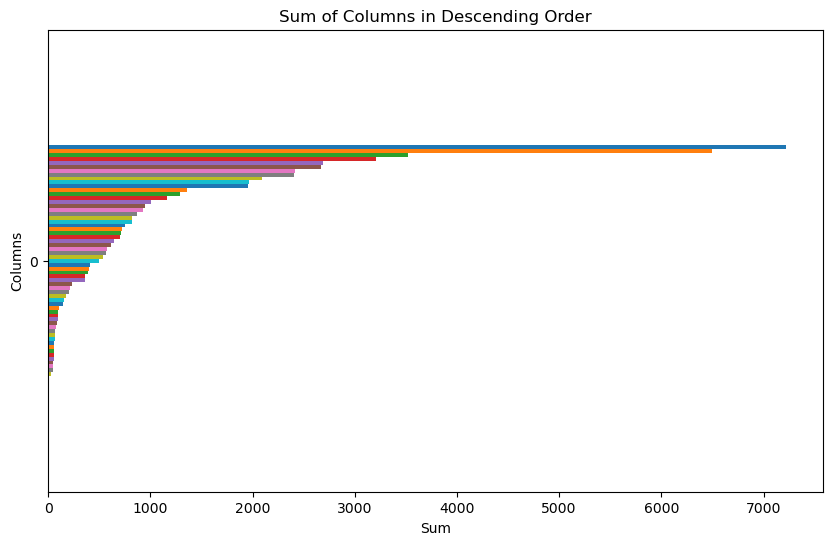

In [178]:
# Step 1: Calculate the sum of each column from the 18th column onwards
sums = ground_news_df.iloc[:, 17:].sum()

# Step 2: Sort these sums in descending order
sorted_sums = sums.sort_values(ascending=False)

# Step 3: Convert the sorted sums to a DataFrame for plotting (with transpose for horizontal bar plot)
sums_df = pd.DataFrame(sorted_sums).T

# Step 4: Plot using a horizontal bar plot
sums_df.plot(kind='barh', legend=None, figsize=(10, 6))  # Adjust figsize as needed

# Optional: Improve the aesthetics
plt.title('Sum of Columns in Descending Order')
plt.xlabel('Sum')
plt.ylabel('Columns')
plt.gca().invert_yaxis()  # This ensures the highest value is on top
plt.show()

## Transformaciones (continuación)

#### Escalados de variables numéricas

Nos faltaba un cabo suelto que atender en cuanto a las variables numéricas: aplicarles un escalado tipo RobustScaler, dado que se trata de variables numéricas no gaussianas, y con outliers. ¿Y cuáles eran esas variables?

In [180]:
ground_news_df.head()

bias_num_sources  all_sources  pct_left  pct_centre  pct_right  low_fact  \
0              15.0         27.0      33.0        47.0       20.0       1.0   
1              76.0         88.0      33.0        38.0       29.0       2.0   
2              46.0         57.0      30.0        31.0       39.0       0.0   
3              23.0         29.0      52.0        35.0       13.0       0.0   
4              18.0         32.0      50.0        17.0       33.0       0.0   

   mixed_fact  high_fact  unknown_fact  own_telecom  own_privateEquity  \
0         2.0       13.0          11.0          4.0                2.0   
1        25.0       48.0          13.0          3.0               11.0   
2        25.0       22.0          10.0          3.0                8.0   
3         7.0       16.0           6.0          2.0                7.0   
4        11.0        8.0          12.0          1.0                2.0   

   own_mediaConglomerate  own_billionaire  own_government  own_independent  \
0                    2.0              2.0             0.0              0.0   
1                   30.0             11.0             6.0             16.0   
2                   13.0             12.0             7.0              8.0   
3                   10.0              2.0             7.0              2.0   
4                    6.0              6.0             3.0              3.0   

   own_other  own_corporation  top_story  breaking_story  \
0        4.0              0.0        0.0             0.0   
1       11.0              0.0        0.0             0.0   
2        7.0              0.0        0.0             0.0   
3        9.0              0.0        0.0             0.0   
4        7.0              0.0        0.0             0.0   

   highlighted_blindspot  es_finde  season_invierno  season_otoño  \
0                    0.0         0                1             0   
1                    0.0         0                1             0   
2                    0.0         0                1             0   
3                    0.0         0                1             0   
4                    0.0         0                1             0   

   season_primavera  season_verano  politics  social  religion  economy  \
0                 0              0         1       1         0        0   
1                 0              0         1       0         0        0   
2                 0              0         1       0         0        0   
3                 0              0         0       0         0        0   
4                 0              0         1       0         0        0   

   technology  international  war  medicine  entertainment  leisure  sports  \
0           0              1    0         0              0        0       0   
1           0              1    1         0              0        0       0   
2           0              1    1         0              0        0       0   
3           0              1    0         0              0        0       0   
4           0              1    1         0              1        0       0   

   crime  police  science  justice  environment  internet_media  offbeat  \
0      0       0        0        0            0               0        0   
1      0       0        0        0            0               0        0   
2      0       0        0        0            0               0        0   
3      0       0        0        0            0               0        0   
4      0       0        0        0            0               0        0   

   disasters  opinion  contentious  united_states  russia  united_kingdom  \
0          0        0            1              0       0               0   
1          0        0            0              0       1               0   
2          0        0            0              1       1               0   
3          0        0            0              0       0               0   
4          0        0            1              0       1             

In [181]:
numericas = ground_news_df.iloc[:, :17]

In [182]:
numericas

bias_num_sources  all_sources  pct_left  pct_centre  pct_right  \
0                 15.0         27.0      33.0        47.0       20.0   
1                 76.0         88.0      33.0        38.0       29.0   
2                 46.0         57.0      30.0        31.0       39.0   
3                 23.0         29.0      52.0        35.0       13.0   
4                 18.0         32.0      50.0        17.0       33.0   
...                ...          ...       ...         ...        ...   
9164              91.0        113.0      20.0        76.0        4.0   
9165             210.0        358.0      31.0        45.0       24.0   
9166               9.0          9.0     100.0         0.0        0.0   
9167              27.0         28.0      63.0        18.0       19.0   
9168              24.0         34.0      42.0        29.0       29.0   

      low_fact  mixed_fact  high_fact  unknown_fact  own_telecom  \
0          1.0         2.0       13.0          11.0          4.0   
1          2.0        25.0       48.0          13.0          3.0   
2          0.0        25.0       22.0          10.0          3.0   
3          0.0         7.0       16.0           6.0          2.0   
4          0.0        11.0        8.0          12.0          1.0   
...        ...         ...        ...           ...          ...   
9164       0.0         1.0       88.0          24.0          0.0   
9165       3.0        71.0      135.0         149.0          0.0   
9166       1.0         8.0        0.0           0.0          1.0   
9167       2.0        20.0        6.0           0.0          2.0   
9168       0.0        12.0       12.0          10.0          0.0   

      own_privateEquity  own_mediaConglomerate  own_billionaire  \
0                   2.0                    2.0              2.0   
1                  11.0                   30.0             11.0   
2                   8.0                   13.0             12.0   
3                   7.0                   10.0              2.0   
4                   2.0                    6.0              6.0   
...                 ...                    ...              ...   
9164               11.0                   39.0              5.0   
9165               16.0                  112.0             29.0   
9166                0.0                    1.0              2.0   
9167                2.0                    8.0              8.0   
9168                1.0                    6.0              5.0   

      own_government  own_independent  own_other  own_corporation  
0                0.0              0.0        4.0              0.0  
1                6.0             16.0       11.0              0.0  
2                7.0              8.0        7.0              0.0  
3                7.0              2.0        9.0              0.0  
4                3.0              3.0        7.0              0.0  
...              ...              ...        ...              ...  
9164             0.0             20.0        6.0              0.0  
9165            18.0             20.0        3.0             22.0  
9166             0.0              1.0        2.0              0.0  
9167             2.0              3.0       11.0              0.0  
9168             1.0              1.0        7.0              0.0  

[9169 rows x 17 columns]

In [183]:
numericas.columns

Index(['bias_num_sources', 'all_sources', 'pct_left', 'pct_centre',
       'pct_right', 'low_fact', 'mixed_fact', 'high_fact', 'unknown_fact',
       'own_telecom', 'own_privateEquity', 'own_mediaConglomerate',
       'own_billionaire', 'own_government', 'own_independent', 'own_other',
       'own_corporation'],
      dtype='object')

In [184]:
# Initialize the RobustScaler
robust_sc = RobustScaler()

# Fit and transform the data and update the dataframe in place
numericas[numericas.columns] = robust_sc.fit_transform(numericas)

In [185]:
numericas

bias_num_sources  all_sources  pct_left  pct_centre  pct_right  \
0             -0.12500     0.046512      0.05        0.08   0.157895   
1              1.78125     1.465116      0.05       -0.28   0.631579   
2              0.84375     0.744186     -0.10       -0.56   1.157895   
3              0.12500     0.093023      1.00       -0.40  -0.210526   
4             -0.03125     0.162791      0.90       -1.12   0.842105   
...                ...          ...       ...         ...        ...   
9164           2.25000     2.046512     -0.60        1.24  -0.684211   
9165           5.96875     7.744186     -0.05        0.00   0.368421   
9166          -0.31250    -0.372093      3.40       -1.80  -0.894737   
9167           0.25000     0.069767      1.55       -1.08   0.105263   
9168           0.15625     0.209302      0.50       -0.64   0.631579   

      low_fact  mixed_fact  high_fact  unknown_fact  own_telecom  \
0          1.0      -0.375  -0.037037      0.428571          4.0   
1          2.0       2.500   1.259259      0.571429          3.0   
2          0.0       2.500   0.296296      0.357143          3.0   
3          0.0       0.250   0.074074      0.071429          2.0   
4          0.0       0.750  -0.222222      0.500000          1.0   
...        ...         ...        ...           ...          ...   
9164       0.0      -0.500   2.740741      1.357143          0.0   
9165       3.0       8.250   4.481481     10.285714          0.0   
9166       1.0       0.375  -0.518519     -0.357143          1.0   
9167       2.0       1.875  -0.296296     -0.357143          2.0   
9168       0.0       0.875  -0.074074      0.357143          0.0   

      own_privateEquity  own_mediaConglomerate  own_billionaire  \
0                   0.0              -0.352941            -0.25   
1                   1.8               1.294118             2.00   
2                   1.2               0.294118             2.25   
3                   1.0               0.117647            -0.25   
4                   0.0              -0.117647             0.75   
...                 ...                    ...              ...   
9164                1.8               1.823529             0.50   
9165                2.8               6.117647             6.50   
9166               -0.4              -0.411765            -0.25   
9167                0.0               0.000000             1.25   
9168               -0.2              -0.117647             0.50   

      own_government  own_independent  own_other  own_corporation  
0                0.0            -0.50   1.000000              0.0  
1                3.0             3.50   3.333333              0.0  
2                3.5             1.50   2.000000              0.0  
3                3.5             0.00   2.666667              0.0  
4                1.5             0.25   2.000000              0.0  
...              ...              ...        ...              ...  
9164             0.0             4.50   1.666667              0.0  
9165             9.0             4.50   0.666667             22.0  
9166             0.0            -0.25   0.333333              0.0  
9167             1.0             0.25   3.333333              0.0  
9168             0.5            -0.25   2.000000              0.0  

[9169 rows x 17 columns]

### Combinación de numéricas escaladas + categóricas creadas:

Aquí tenemos el dataframe resultante de incorporar las nuevas categóricas de temas, países y sentimiento y escalar las numéricas:

In [186]:
clean_ground_news_df = pd.concat([numericas, ground_news_df.iloc[:, 17:]], axis=1)
clean_ground_news_df

bias_num_sources  all_sources  pct_left  pct_centre  pct_right  \
0             -0.12500     0.046512      0.05        0.08   0.157895   
1              1.78125     1.465116      0.05       -0.28   0.631579   
2              0.84375     0.744186     -0.10       -0.56   1.157895   
3              0.12500     0.093023      1.00       -0.40  -0.210526   
4             -0.03125     0.162791      0.90       -1.12   0.842105   
...                ...          ...       ...         ...        ...   
9164           2.25000     2.046512     -0.60        1.24  -0.684211   
9165           5.96875     7.744186     -0.05        0.00   0.368421   
9166          -0.31250    -0.372093      3.40       -1.80  -0.894737   
9167           0.25000     0.069767      1.55       -1.08   0.105263   
9168           0.15625     0.209302      0.50       -0.64   0.631579   

      low_fact  mixed_fact  high_fact  unknown_fact  own_telecom  \
0          1.0      -0.375  -0.037037      0.428571          4.0   
1          2.0       2.500   1.259259      0.571429          3.0   
2          0.0       2.500   0.296296      0.357143          3.0   
3          0.0       0.250   0.074074      0.071429          2.0   
4          0.0       0.750  -0.222222      0.500000          1.0   
...        ...         ...        ...           ...          ...   
9164       0.0      -0.500   2.740741      1.357143          0.0   
9165       3.0       8.250   4.481481     10.285714          0.0   
9166       1.0       0.375  -0.518519     -0.357143          1.0   
9167       2.0       1.875  -0.296296     -0.357143          2.0   
9168       0.0       0.875  -0.074074      0.357143          0.0   

      own_privateEquity  own_mediaConglomerate  own_billionaire  \
0                   0.0              -0.352941            -0.25   
1                   1.8               1.294118             2.00   
2                   1.2               0.294118             2.25   
3                   1.0               0.117647            -0.25   
4                   0.0              -0.117647             0.75   
...                 ...                    ...              ...   
9164                1.8               1.823529             0.50   
9165                2.8               6.117647             6.50   
9166               -0.4              -0.411765            -0.25   
9167                0.0               0.000000             1.25   
9168               -0.2              -0.117647             0.50   

      own_government  own_independent  own_other  own_corporation  top_story  \
0                0.0            -0.50   1.000000              0.0        0.0   
1                3.0             3.50   3.333333              0.0        0.0   
2                3.5             1.50   2.000000              0.0        0.0   
3                3.5             0.00   2.666667              0.0        0.0   
4                1.5             0.25   2.000000              0.0        0.0   
...              ...              ...        ...              ...        ...   
9164             0.0             4.50   1.666667              0.0        0.0   
9165             9.0             4.50   0.666667             22.0        0.0   
9166             0.0            -0.25   0.333333              0.0        0.0   
9167             1.0             0.25   3.333333              0.0        0.0   
9168             0.5            -0.25   2.000000              0.0        0.0   

      breaking_story  highlighted_blindspot  es_finde  season_invierno  \
0                0.0                    0.0         0                1   
1                0.0                    0.0         0                1   
2                0.0                    0.0         0                1   
3                0.0                    0.0         0                1   
4                0.0                    0.0         0                1   
...              ...                    ...       ...              ...   
9164             0.0                    

In [187]:
### CHECKPOINT!!!

# Para no tener que correr todo el código cada vez, usamos el módulo pickle para aplicar un "dump".
# Atención! Aquí el nombre de fichero es diferente.
clean_ground_news_df.to_pickle('clean_ground_news_df.pkl')


Aprovecharé este fichero para trabajar aparte el clustering en otro notebook limpio.

## Análisis visual del dataframe de trabajo:

Calculo la matriz de correlación para las numéricas.

In [188]:
# Calculate the correlation matrix
corr_matrix = clean_ground_news_df.iloc[:,:17].corr()

Represento la matriz mediante un "heatmap" (pero sin anotaciones, para que sea legible al menos mediante los colores):

#### Heatmap de correlación entre variables numéricas

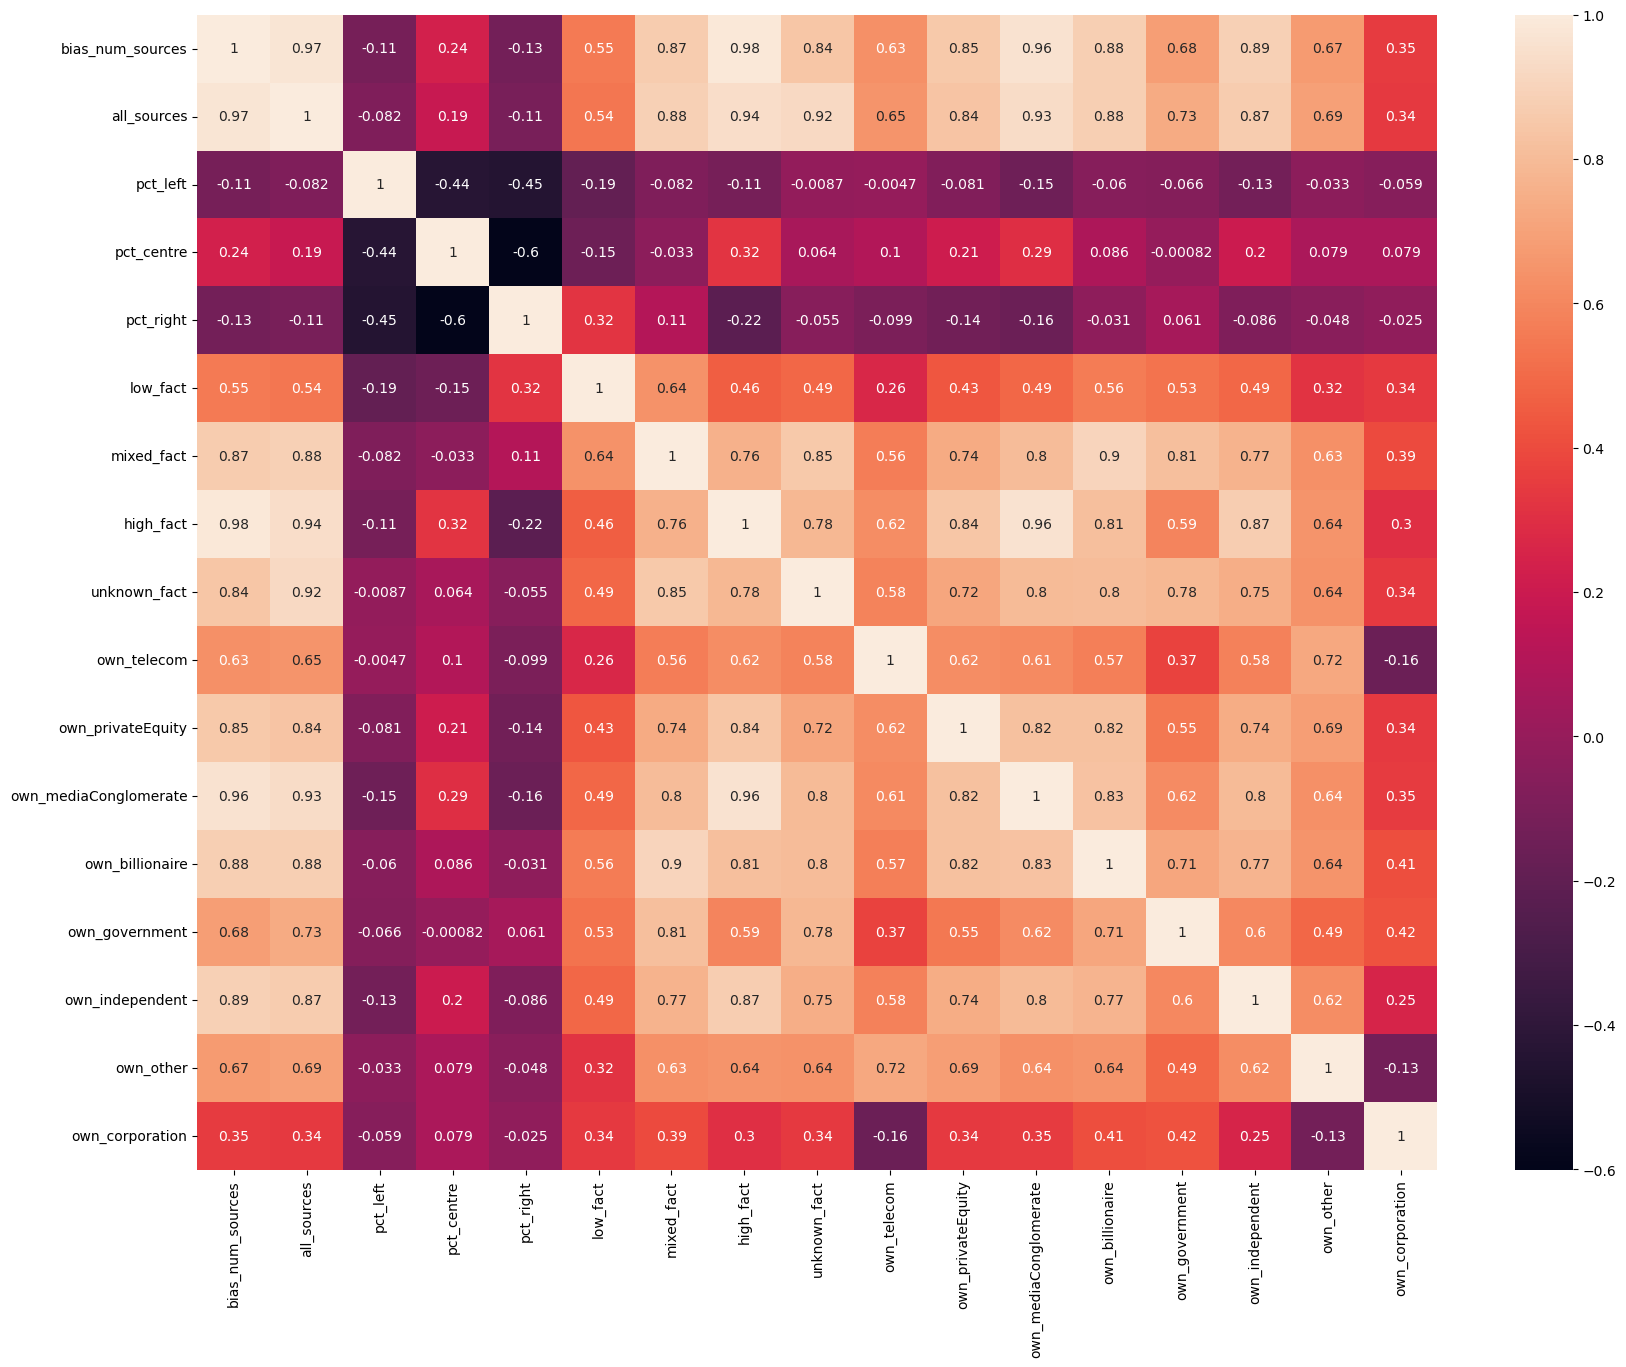

In [189]:
# Assuming `corr_matrix` is your correlation matrix
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(corr_matrix, annot=True)
plt.savefig('heatmap_no_numbers.png', dpi=300)

#### Pairplot:

In [190]:
print(clean_ground_news_df.iloc[:, :17].columns)

Index(['bias_num_sources', 'all_sources', 'pct_left', 'pct_centre',
       'pct_right', 'low_fact', 'mixed_fact', 'high_fact', 'unknown_fact',
       'own_telecom', 'own_privateEquity', 'own_mediaConglomerate',
       'own_billionaire', 'own_government', 'own_independent', 'own_other',
       'own_corporation'],
      dtype='object')


C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


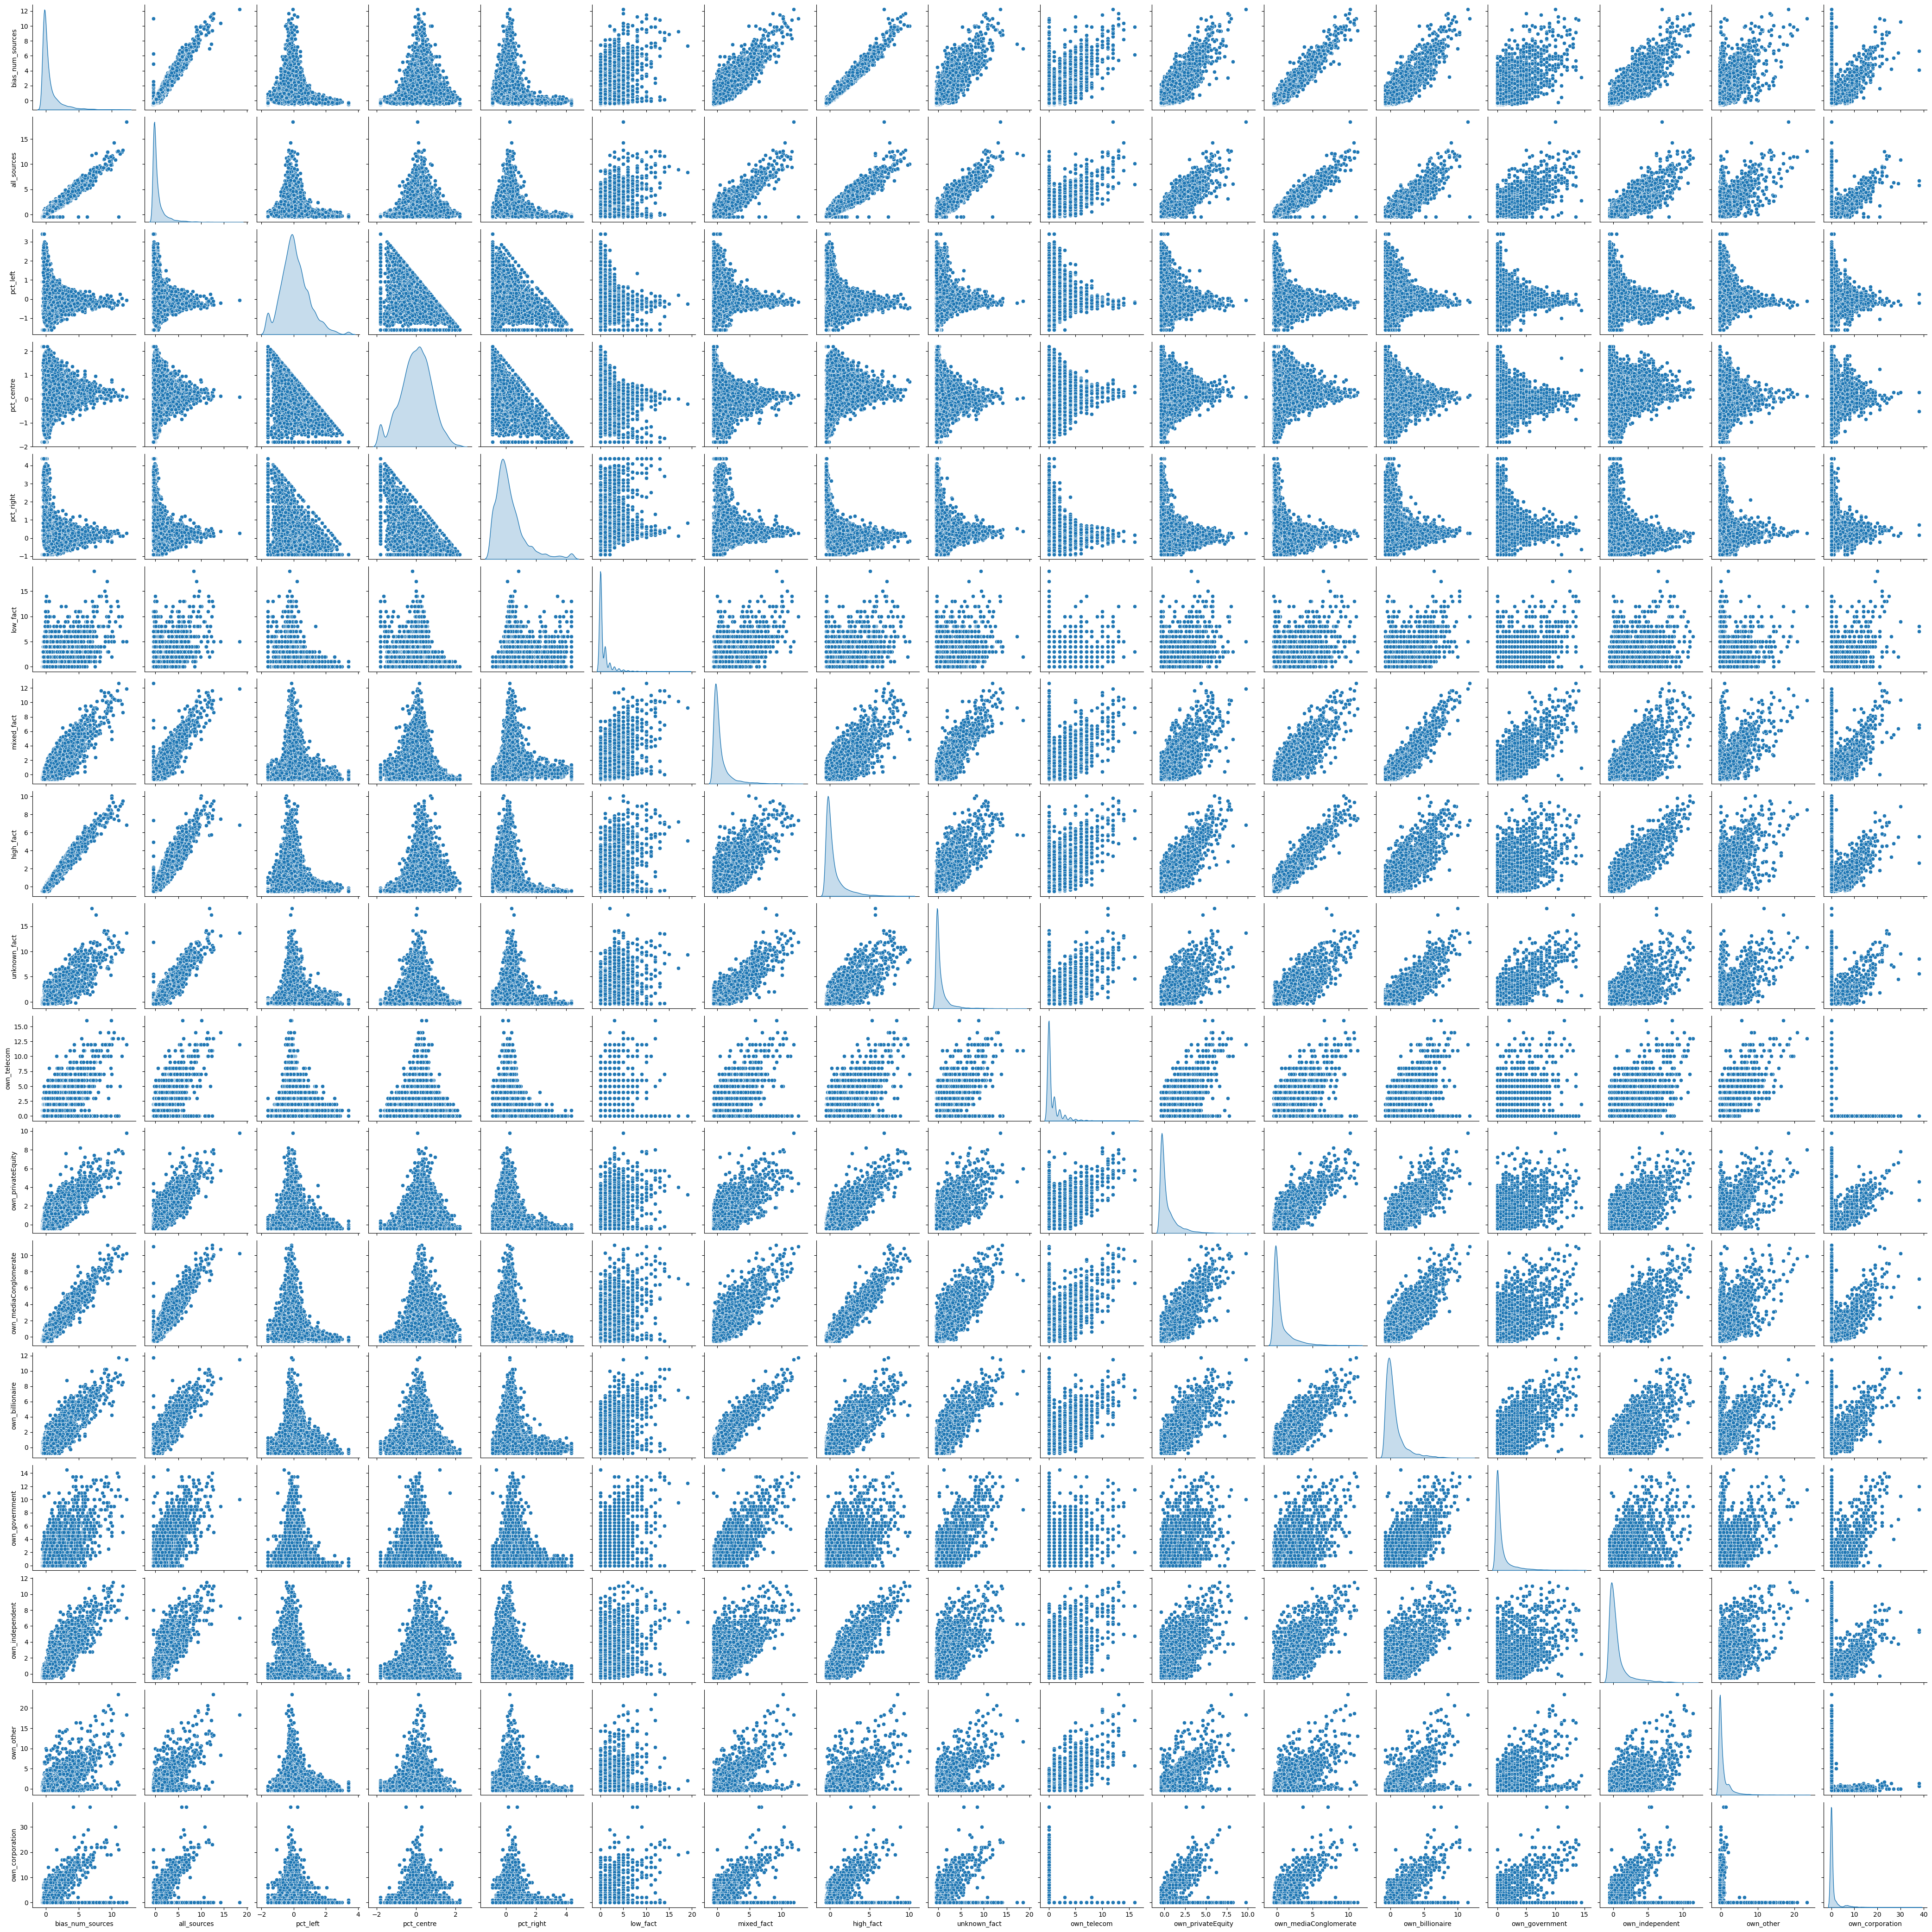

In [191]:
sns.pairplot(clean_ground_news_df.iloc[:, :17], diag_kind='kde')

In [ ]:
CANTIDAD DE NOTICIAS IZQ, DERECHA, 

In [ ]:
NUMÉRICAS ONLY